# CS323 Project 1: Regression and Classification

<button disabled>

**Author:** [Modar Alfadly](http://modar.me) and [Hasan Abed Al Kader Hammoud](https://scholar.google.com/citations?user=Plf1JSIAAAAJ&hl=en)

**Due Date:** 23 Feb 2022 @ 11:59 PM

</button>

**Student Name: David Felipe Alvear Goyes**

**KAUST ID: 187594**

**Degree: Electrical and Computer Engineering**

**Major: Robotics and autonomous systems**

To setup a conda environment for this project, just run the following commands:

```shell
conda create -n cs323 python=3.9.1 -y
conda activate cs323

conda install pytorch torchvision torchaudio cudatoolkit=11.0 -c pytorch -c conda-forge -y  # install PyTorch 1.7.1
conda install jupyter -y  # to edit this file
conda install jedi=0.17.2 -y  # https://github.com/ipython/ipython/issues/12740
conda install matplotlib -y  # for plotting
conda install requests -y  # to download Google Drive files

pip install jupyter_http_over_ws  # for Google Colab
jupyter serverextension enable --py jupyter_http_over_ws  # Google Colab
```

## Remarks 


Welcome to CS323, this is your first assignment where you will learn the basics of PyTorch and some Deep Learning techniques. We would like to note that the grading of the assignments will be based on meeting with the TAs, running the code and answering technical questions related to parts labeled with "TODO". You are not supposed to fill your answers under the questions as you will be asked to answer these verbally. Additionally, we attach a pdf file named `cs323_getting_started.pdf` for the beginners to Conda and the KAUST GPU cluster (Ibex). 

# Part 1: Regression (3 points)

## Task 1: gradient descent (1 point)

One of the benefits of using PyTorch is the [automatic differentiation](https://medium.com/@ODSC/automatic-differentiation-in-pytorch-6131b4581cdf) feature. Suppose, that you want to compute the derivative of a composite function with respect to one of its inputs. As long as you can construct the function in PyTorch's basic operations, you can ask it to compute any gradient for you very efficiently. 

Let's take this function as an example:
$$f(x) = \frac{\arctan\left(x^{3}\right)}{x}$$



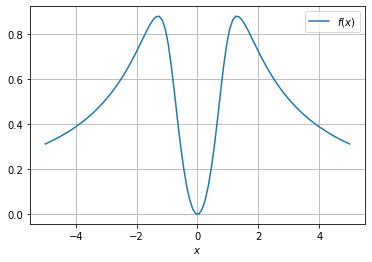

In [2]:
import torch

from matplotlib import pyplot as plt


def f(x):
    return torch.arctan(x**3) / x


xs = torch.linspace(start=-5, end=5, steps=100)
ys = f(xs)

plt.plot(xs, ys, label='$f(x)$')
plt.xlabel('$x$')
plt.legend()
plt.grid()
plt.show()

We can rewrite it as a composition of functions (forward-pass).
$$f(x) = g(h(k(x)), x) ~\text{where}~ k(x) = x^3, h(x) = \arctan\left(x\right), g(x, y) = \frac{x}{y}$$

Now we can find its derivative by leveraging the [chain rule](https://en.wikipedia.org/wiki/Chain_rule) (backward-pass).
$$\frac{d f(x)}{dx} = \frac{3x}{x^6 + 1} - \frac{\arctan\left(x^{3}\right)}{x^2}$$

PyTorch implements the [backpropagation](https://en.wikipedia.org/wiki/Backpropagation) algorithm which repeatedly applys the chain rule to automatically compute gradients at a given point. Internally, it dynamically represents the function as a graph where the nodes are the tensors and the edges are the operations that are done to them. Since it knows the partial derivatives of each operation to its inputs (e.g. $g$, $h$, and $k$), propagating the output gradients becomes a mechanical task.

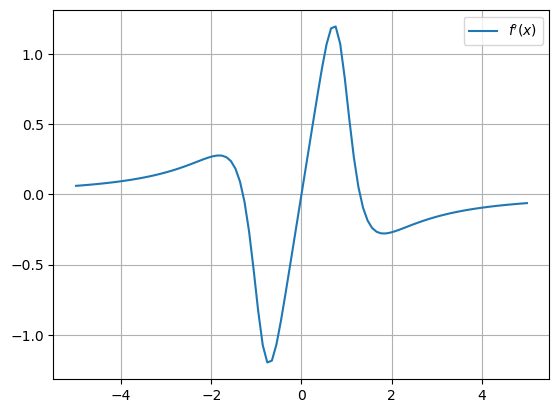

In [2]:
xs = torch.linspace(-5, 5, steps=100, requires_grad=True)
ys = f(xs)

# TODO: understand this line, TA will ask you during the grading session. ones_like
# read the docs Tensor.backward: https://pytorch.org/docs/stable/tensors.html
# torch.ones_like(ys) - Set the gradient respect to the output to 1, how much the how much the output would change if the input were to change by a small amount
# ys.backward - Compute the gradient of the tensor ys related to the input xs having set requires_grad=true.
# Apply chain rule from output to inputs, compute the gradient of ys respect to the variable xs. Gradient especified to relate the sensibility of changes of output given input change
ys.backward(torch.ones_like(ys))

plt.plot(xs.data, xs.grad, label='$f\'(x)$')
plt.legend()
plt.grid()
plt.show()

We need the ability to compute gradients to apply the [gradient descent](https://en.wikipedia.org/wiki/Gradient_descent) algorithm which is the most fundamental optimization tool for machine learning.

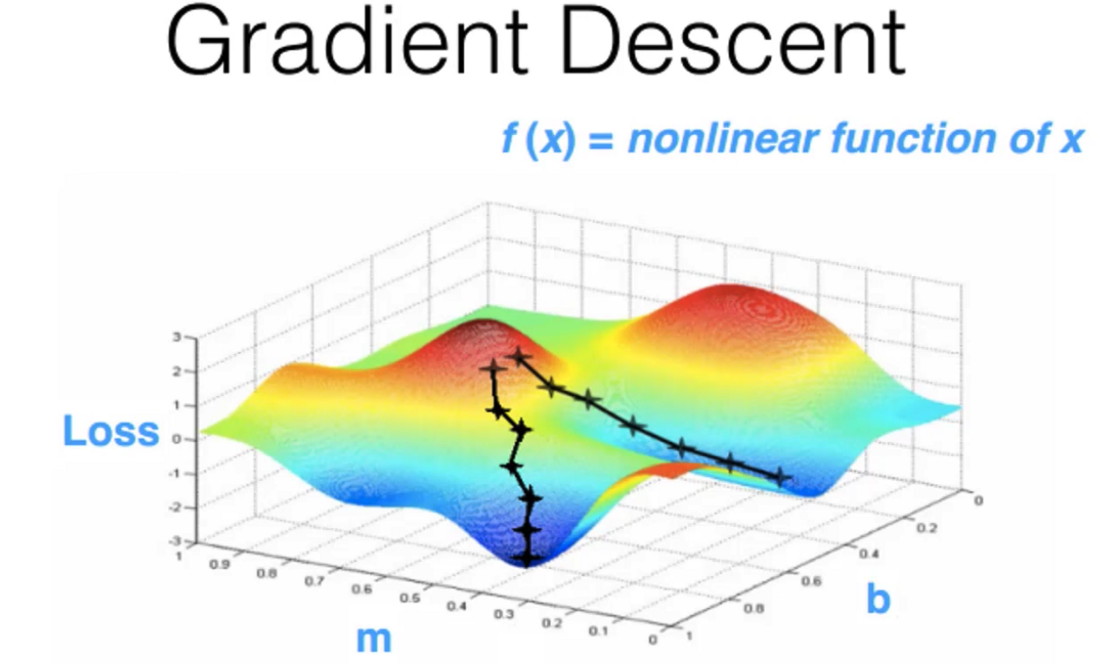

Let's start with a slightly modified function where the goal is to find a local minimum point using gradient descent.
$$f(x) =\text{sign}(x) \frac{\arctan\left(x^{3}\right)}{x}$$

Of course, we can find the minimizer of this functoin by checking where the gradient is zero. However, this is just an example with a single variable. In a real scenario, we don't have an analytical closed form solution for the gradient and the function could have millions and maybe billions of parameters.

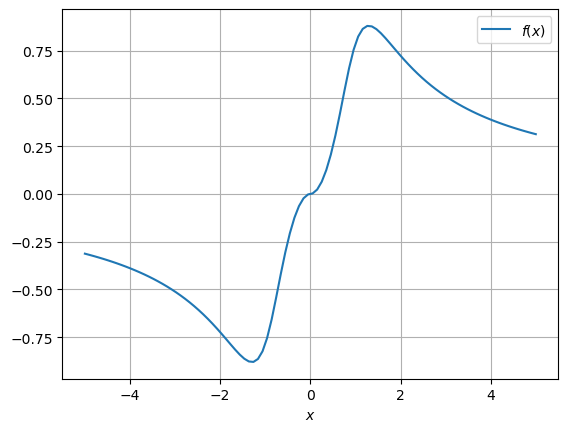

In [3]:
def f(x):
    return torch.sign(x) * torch.arctan(x**3) / x


# TODO: vvvvvvvvvvv
# plot the function f(x) as before 
xs = torch.linspace(start=-5, end=5, steps=100)
ys = f(xs)

plt.plot(xs, ys, label='$f(x)$')
plt.xlabel('$x$')
plt.legend()
plt.grid()
plt.show()

# ^^^^^^^^^^^^^^^^^

In [4]:
# Implemment gradient descend algorithm to optimize the function respect to x
# Find a local minimum in the function
def gradient_descent(initial_point, step_size, num_iterations):
    losses = [] # List to save the loss values in the iterations
    # Check if initial_point is a tensor
    if not torch.is_tensor(initial_point):
        # Convert initial_point to tensor with dtype float
        initial_point = torch.full((), initial_point, dtype=torch.float)
    # Create a feature tensor x as a clone of initial_point setting requires_grad
    # to keep track of the gradient respect to x
    x = initial_point.data.clone().requires_grad_(True)
    for i in range(num_iterations):
        loss = f(x) # Compute the objective (forward-pass)

        x.grad = None # Zero out the gradient of x
        loss.backward() # Compute the gradient (backward-pass)
        x.data = x.data - step_size * x.grad # Take one step

        # Store the loss per iteration in a list 
        losses.append(loss.item())
    return x.detach(), losses

Let's now use this method to find the minimum value of our function using different initializations and hyper-parametrs (e.g., learning rate, number of iterations).

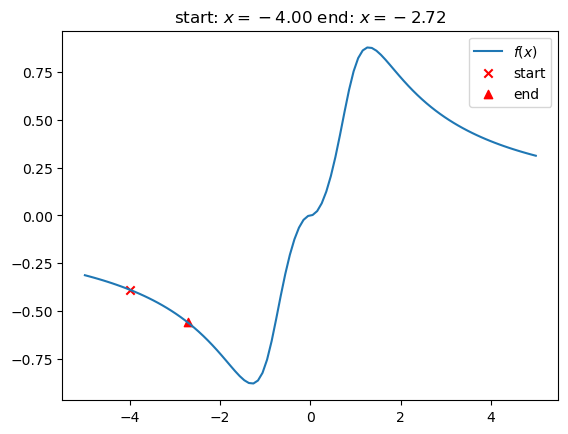

/tmp/ipykernel_98453/3440155978.py:56: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525551200/work/aten/src/ATen/native/TensorShape.cpp:3277.)
  plt.plot(iter, torch.tensor(losses).T, label='$f(x)$')


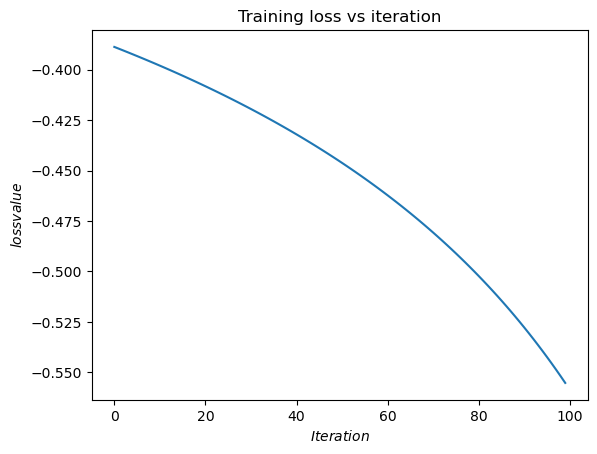

###########################


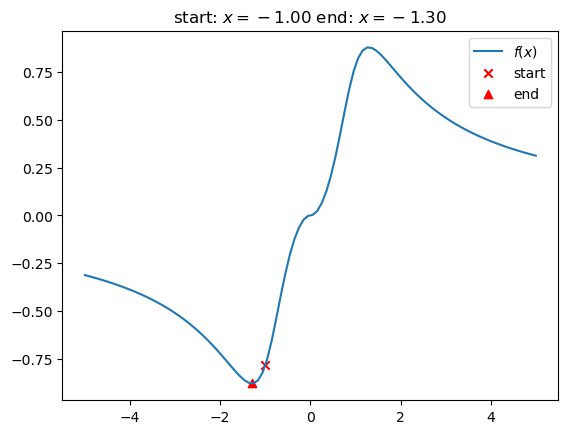

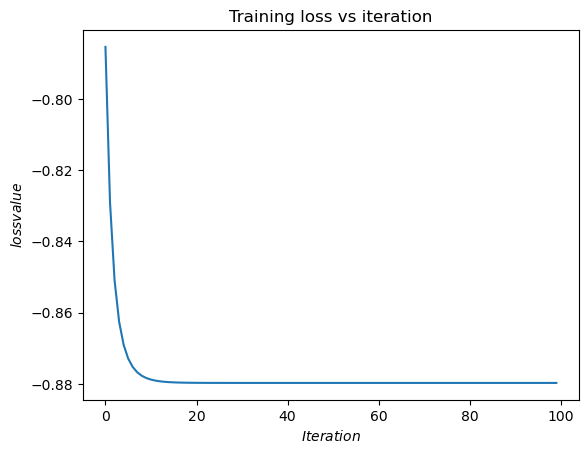

###########################


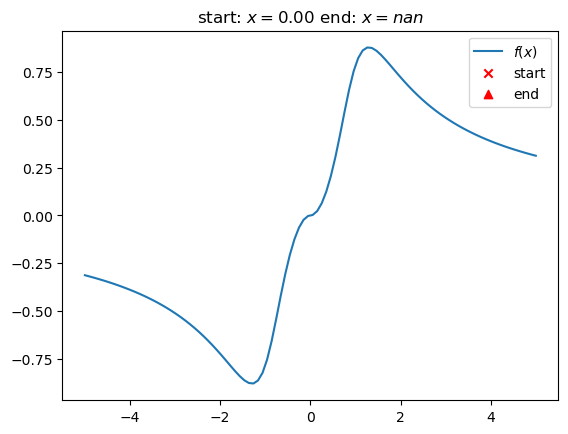

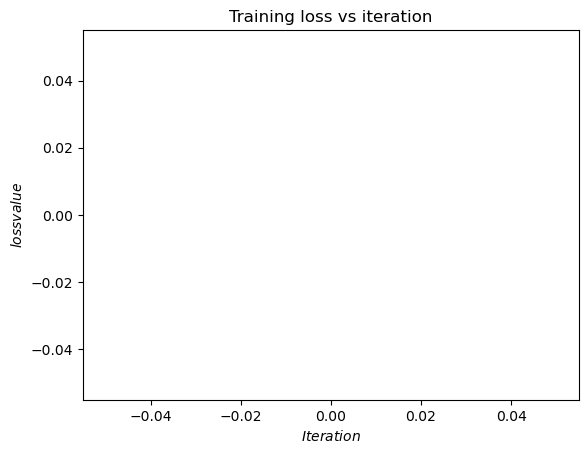

###########################


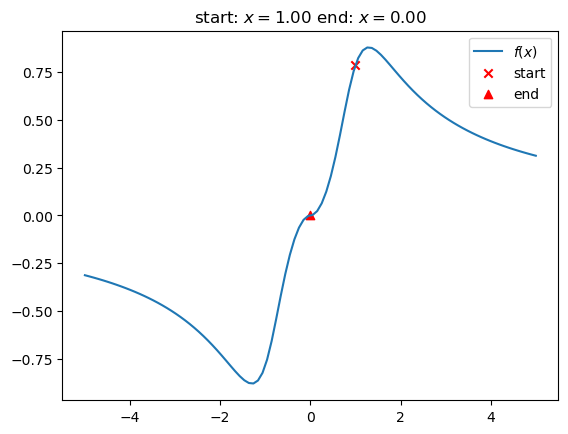

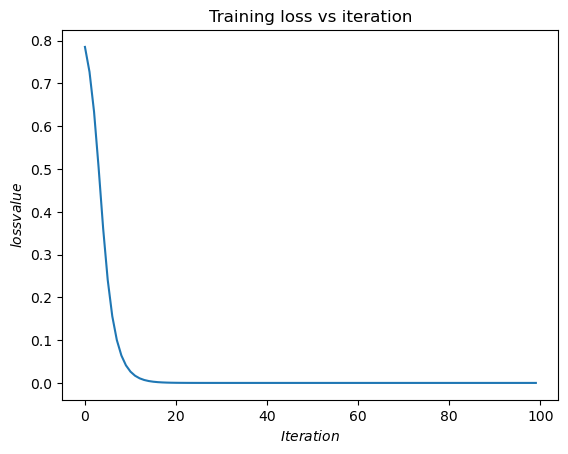

###########################


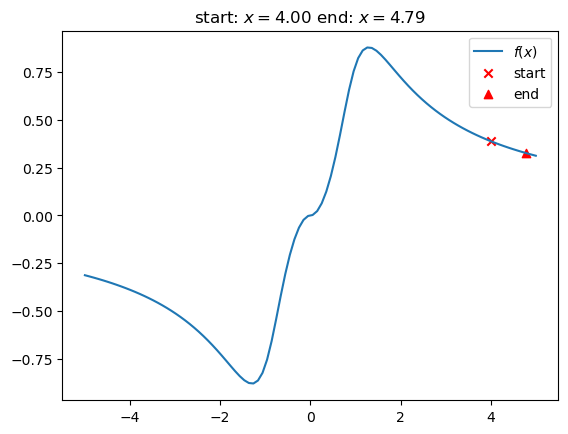

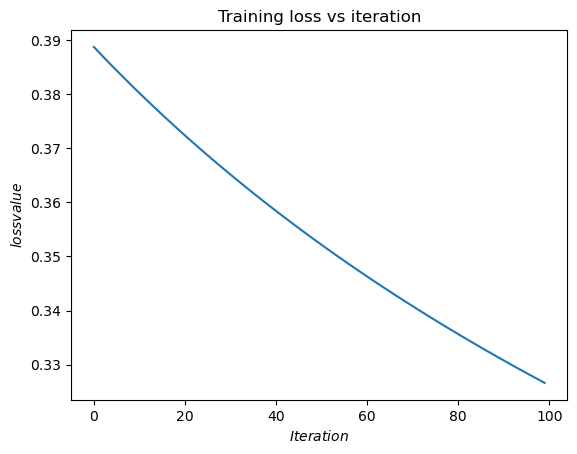

###########################


In [5]:
# TODO: how does the initialization changes the result
""" 
initial value affects:
    - How fast the optimizer finds a local minimum
    - We can have different local minimums, and the result depends on the initial value
    - Affect the convergence of the algorithm (x=0 inf value)
    - The initial value selection can lead that GD overshoot the local minima
"""
# TODO: how should we choose the learning rate and the iterations
""" 
We should choose the learning rate and the iterations
to converge the algorithm to a local minimum. If the learning rate is to
large could lead to a quick convergence as well as having a high value of iterations,
resulting in small changes in the loss after finding the local minimum, also could happen
that the point finded is outside of the defined range. To choose the learning rate and the
iterations we need to configure this values to converge to the local minimum, the combination
of the two could lead to escape from a saddle point. Having a high learning rate at the begining
and then reduce it when there is no update in the loss, while having the iterations necessaries 
to converge.

In the experimentation we have to configure the two values to converge to a local minima
in a reasonable amount of time, define the values in a right balance.
    - High learning rate values could lead to fast convergence but can overshoot the minimum
    - Slow learning rate could take to much time to converge to a local minimum, or don't converge
        if the iterations are not enough.
    - The number of iterations gives the time to converge to a local minimum, small values do not converge
"""
# TODO: what happens when we initialize at 0 
""" 
Given that point 0 is a saddle point the gradient descend doesn't converge to a 
local minima, tha characteristics of the saddle point is that the gradient is 
zero because it is considered a critical point, then the algorithm can not
update in the iterations due to the value of the gradient at this point.
"""
steps = 100
learning_rate = 0.1
for x_0 in [-4, -1, 0, 1, 4]:
    x_n, losses = gradient_descent(
        initial_point=x_0,
        step_size=learning_rate,
        num_iterations=steps,
    )

    # plot the results
    xs = torch.linspace(-5, 5, steps=100)
    plt.plot(xs, f(xs), label='$f(x)$')
    plt.scatter([x_0], [losses[0]], color='red', marker='x', label='start')
    plt.scatter([x_n], [losses[-1]], color='red', marker='^', label='end')
    plt.title(f'start: $x={x_0:.2f}$ end: $x={x_n:.2f}$')
    plt.legend()
    plt.show()

    # TODO: vvvvvvvvvvv
    # plot the training loss [x-axis:iteration, y-axis:loss_value] 
    iter = torch.linspace(0,99,steps=100) # Create a tensor with the itereation values
    plt.plot(iter, torch.tensor(losses).T, label='$f(x)$')
    plt.title('Training loss vs iteration')
    plt.xlabel('$Iteration$')
    plt.ylabel('$loss value$')
    # plt.grid()
    plt.show()

    # ^^^^^^^^^^^^^^^^^
    print('###########################')

## Task 2: `torch.nn.Module`, `torch.optim.Optimizer`, and `torch.utils.data` (2 points)

PyTorch has many variants of gradient descent optimizers like gradient descent with Nesterov momentum and Adam. You can learn more about them in the [documentation](https://pytorch.org/docs/stable/optim.html) or in this [blog post](https://ruder.io/optimizing-gradient-descent/). They all inherent from the base [`torch.optim.Optimizer`](https://pytorch.org/docs/stable/optim.html#torch.optim.Optimizer) class. We want to change the code above to conform to the conventional PyTorch pipeline.

However, as we mentioned before, in real scenarios, the functions that we try to minimize are more complicated. They are parametric models with the following form $y \approx f(x; \theta)$, where $x$ contains the independent input variables (features), $\theta$ contains the parameters that we need to learn, and $y$ contains the dependent output variables. [Regression](https://en.wikipedia.org/wiki/Regression_analysis) is a perfect example of such problem, where we want to fit a parametric function (model) to some given data (training). The data are given to us as a finite set of $(x, y)$ pairs. For a chosen analytical form of $f(x; \theta)$ (e.g. linear $f(x; \theta) = m x + b$ where $\theta = \{m, b\}$), we want to find the best value of $\theta$ that makes $f(x; \theta)$ as close as possible to $y$ according to some criterion ([loss function](https://en.wikipedia.org/wiki/Loss_function) such as the mean squared error $\left(f(x; \theta) - y\right)^2$). Since we have limited data, we usually train for multiple episodes (epochs); every epoch is one full run over the entire training dataset. Finally, each epoch can be done in a single iteration (standard gradient descent) or multiple iterations (the data could be batched or each iteration will train only on a single input-ouput pair). See [stochastic gradient descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent).

In the previous task (Part1.Task1), we didn't have input features $x$ or output variables $y$ (no data). In fact, our old input $x$ is what we refer to here as the parameter $\theta$. So, let's add those edits to our gradient_descent function.

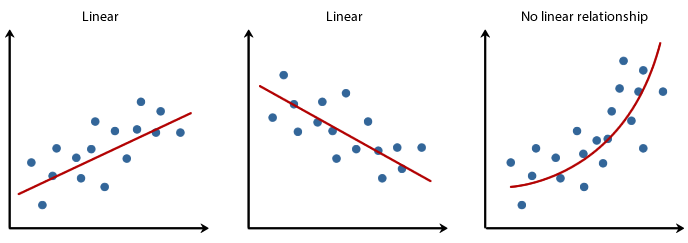

In [8]:
# TODO: understand every line of the following method
# model - model to be optimized 
# learning_rate - step size to update the parameters
# num_epochs - Iterations that the algorithm will run over the dataset
# data_loader - pytorch data loader that create the mini batches
# criterion - loss function to calculate the error between predictions and outputs
def gradient_descent(model, learning_rate, num_epochs, data_loader, criterion):
    losses = []
    # Configure the optimizer to oupdate the parameters of the model
    optimizer = torch.optim.SGD(model.parameters(), learning_rate)
    for epoch in range(num_epochs):  # one epoch
        # Get the first mini_batch of (inputs,outputs) to perform SGD
        for inputs, outputs in data_loader:  # one 
            # Predict with the model and get the loss function
            # Using the outputs
            loss = criterion(model(inputs), outputs)  # forward-pass

            # Given that the grad is accumulative we need to set to zero
            optimizer.zero_grad()  # zero out the gradients
            # Perform the backward pass to compute the gradient respecto to model aprameters
            loss.backward()  # compute the gradients (backward-pass)
            # Update the parameters of the model
            optimizer.step()  # take one step

            losses.append(loss.item()) # Add to the list of losses the loss calulated
        # Calulate the loss for the epoch to display
        # Sum the losses of the data in the dataloader and divide by the number of elements
        # in the dataloader
        loss = sum(losses[-len(data_loader):]) / len(data_loader)
        print(f'Epoch #{epoch}: Loss={loss:.3e}') # Print the information for current epoch
    return losses

In [9]:
import torch.nn as nn

class PolynomialModel(nn.Module):
    """Generic model for a polynomial of any degree"""
    def __init__(self, degree):
        super().__init__()
        assert int(degree) == degree and degree >= 0 # sanity check

        # define the model parameters (order-decreasing)
        # all sub_modules and parameters must be direct attributes of self
        self.coefficients = nn.Parameter(torch.ones([degree + 1]))
    
    def forward(self, x):
        coefficients = iter(self.coefficients)
        out = torch.zeros_like(x)
        out += next(coefficients, 0)
        for c in coefficients:
            out *= x
            out += c
        return out

class Linearmodel(PolynomialModel):
    """Scalar linear model `f(x) = m x + b`"""
    def __init__(self):
        super().__init__(degree=1)


Let's solve the following regression problem. Find the closest third-degree polynomial to $f(x) = x^6 - 3x^5 - x^3 + 3x$ in the range $[-2, 2]$.

In [10]:
import torch.nn as nn

# TODO: understand the Models here (PolynomialModel, Linearmodel, init, nn.Parameter, forward pass ...) 
"""
nn.Module - Base abstract class for pytorch models, provide methods for developing custom models
__init__ - Initialize the class PolynomialModel which could represent any polynomial giving the degree

"""
class PolynomialModel(nn.Module):
    """Generic model for a polynomial of any degree."""
    def __init__(self, degree):
        super().__init__()  # Initialize the __init__ of the parent class nn.module
        # Check if the degree is positive integer
        assert int(degree) == degree and degree >= 0  # sanity check
        
        # define the model parameters (order-decreasing)
        # all sub_modules and parameters must be direct attributes of self
        # Initialize the parameters of the model setting them to 1 and 
        # correpond to the coefficients of the polynomial
        self.coefficients = nn.Parameter(torch.ones([degree + 1]))

    def forward(self, x):
        # Create an iterator of the coefficients that they are of nn.Parameter type
        coefficients = iter(self.coefficients)
        # Create a tensor for the output of the polynomial
        out = torch.zeros_like(x)
        # Return the first element of the iterator (coefficient) and sume the value to the out tensor
        out += next(coefficients, 0)
        # Iterate over the coefficients
        for c in coefficients:
            out *= x # multiply by c
            out += c # add the coefficient
        return out


# Initialize a linear model degree=1 extending the PolynomialModel class
class Linearmodel(PolynomialModel):
    """Scalar linear model `f(x) = m x + b`."""
    def __init__(self):
        super().__init__(degree=1) # Initialize the init function of the parent class

Let's generate the training dataset. We will first define the ground-truth model and freeze its parameters. Then, use it to generate point pairs in the range $[-2, 2]$.

In [11]:
from torch.utils.data import TensorDataset, DataLoader

# Call the class PolynomialModel and define a polynomial of degree=6
f = PolynomialModel(degree=6)
# Define that the gradients won't be computed respecto the coefficients in the training
# Initially the coefficients are all equal to one
f.coefficients.requires_grad_(False)
# Set manually the coefficients of the polynomial as a float tensor
f.coefficients.data = torch.FloatTensor([1, -3, 0, -1, 0, 3, 0])

torch.manual_seed(0) # define a seed to generate data
xs = 2 * (torch.rand(1000) * 2 - 1) # create random points in the range -2 to 2
# Create a tensor dataset with the point pairs in the defined range, and evaluated in the polynomial
# print(iter(f.coefficients))
# TensorDataset ready class to represent data as a list of tensors x and y
dataset = TensorDataset(xs, f(xs)) # use as a data source for training and evaluation

"""
Defined polynomial model
Added the coefficients for the model
created the dataset using the TensorDataset class to convert to tensors.
"""

'\nDefined polynomial model\nAdded the coefficients for the model\ncreated the dataset using the TensorDataset class to convert to tensors.\n'

In [12]:
# TODO: study the following parameters of the data loader
# https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader
# the goal of the data loader is to batch multiple samples "(x, y) pairs"
# on the fly and make them ready for training by using multiprocessing
# it is important to differentiate between Dataset() and DataLoader()
""" 
DataLoader is a pytorch class that helps to load and iterate over the elements in the dataset
- batch_size: Determine the number of training samples to use in each iteration
- shuffle: If it is true the samples are shuffled and loaded in batches
- num_workers: Allow multiprocessing to handle the dataset, loading and preprocessing
- pin_memory: Indicate if the data is loaded as cuda tensors
- collate_fn: Used to merge datasets, when batches loaded from map-styled datasets

"""
data_loader = DataLoader(
    dataset,
    batch_size=20,
    shuffle=True,
    num_workers=1,
    drop_last=True,
    pin_memory=False,
    collate_fn=None,
)

Epoch #0: Loss=7.403e+02
Epoch #1: Loss=2.728e+02
Epoch #2: Loss=1.930e+02
Epoch #3: Loss=1.688e+02
Epoch #4: Loss=1.568e+02
Epoch #5: Loss=1.494e+02
Epoch #6: Loss=1.439e+02
Epoch #7: Loss=1.394e+02
Epoch #8: Loss=1.354e+02
Epoch #9: Loss=1.316e+02
Epoch #10: Loss=1.284e+02
Epoch #11: Loss=1.250e+02
Epoch #12: Loss=1.219e+02
Epoch #13: Loss=1.192e+02
Epoch #14: Loss=1.165e+02
Epoch #15: Loss=1.139e+02
Epoch #16: Loss=1.115e+02
Epoch #17: Loss=1.092e+02
Epoch #18: Loss=1.071e+02
Epoch #19: Loss=1.050e+02
Epoch #20: Loss=1.032e+02
Epoch #21: Loss=1.011e+02
Epoch #22: Loss=9.964e+01
Epoch #23: Loss=9.768e+01
Epoch #24: Loss=9.625e+01
Epoch #25: Loss=9.476e+01
Epoch #26: Loss=9.352e+01
Epoch #27: Loss=9.213e+01
Epoch #28: Loss=9.075e+01
Epoch #29: Loss=8.937e+01
Epoch #30: Loss=8.846e+01
Epoch #31: Loss=8.723e+01
Epoch #32: Loss=8.624e+01
Epoch #33: Loss=8.515e+01
Epoch #34: Loss=8.427e+01
Epoch #35: Loss=8.322e+01
Epoch #36: Loss=8.246e+01
Epoch #37: Loss=8.169e+01
Epoch #38: Loss=8.080e

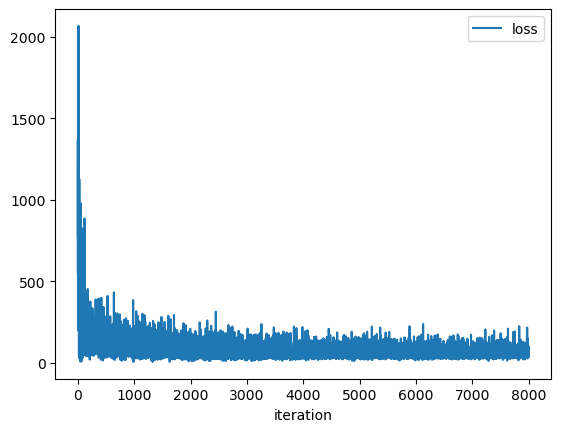

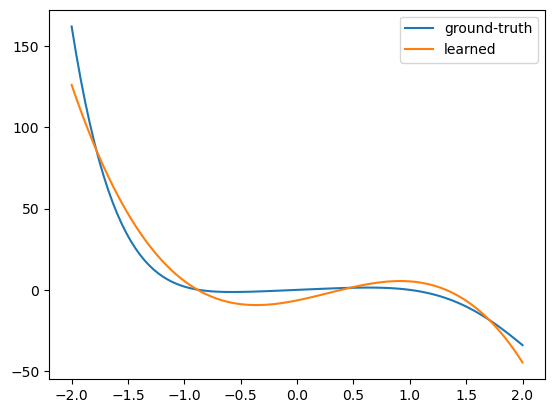

In [13]:
# TODO: vvvvvvvvvvv
# understand and change the following
# you must achieve a mean squared error of at most 61

torch.manual_seed(0) # Define the seed to generate the data
model = PolynomialModel(degree=3) # Create a polynomial model degree=3
# Train the model using SGD algorithm
losses = gradient_descent(
    model,
    learning_rate=0.001,
    num_epochs=160,
    data_loader=data_loader,
    criterion=nn.MSELoss(),
)
# ^^^^^^^^^^^^^^^^^

# Compute the loss of the training 
loss = sum(losses[-len(data_loader):]) / len(data_loader)
print(f'Average loss for last epoch: {loss}')

# plot the training loss
plt.plot(range(len(losses)), losses, label='loss')
plt.xlabel('iteration')
plt.legend()
plt.show()

# plot the ground-truth model vs the learned model
xs = torch.linspace(-2, 2, steps=100)
plt.plot(xs, f(xs), label='ground-truth')
plt.plot(xs, model(xs).data, label='learned')
plt.legend()
plt.show()

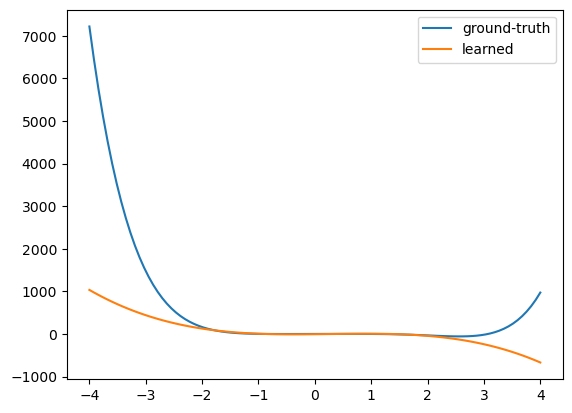

" \nOverfitting:\nOverfitting occurs when a model can not capture the structure of the data\nand it learns closely or exactly the training data.\nIt could occur when the model is too complex and then it start to learn the noise, also \nwhen the number of paramters is relative greater than the size of the training data.\nThe effects of this is a high accuracy on training data but poorly on new data.\nOther way that overfitting could occur is when a model is trained in a biased dataset, the problem\nis that the set of data doesn't represent the distribution of data. This could lead to train on biased\ndata nor underlying parameters.\n\nThe effect of the testing in a different range of data could lead to a poor performance,\nwe trained the polynomial model in a defined range, and after expanding this the performance\nreduced considerably. This means that we have overfitting and the model learned the training data,\nThe training data should have a representative set of data that the model 

In [14]:
# TODO: vvvvvvvvvvv
# create a testing set in the range [-4, 4] and its data loader
torch.manual_seed(0) # define a seed to generate data
# xs_test = 4 * (torch.rand(1000) * 2 - 1) # create random points in the range -4 to 4
xs_test = torch.linspace(-4, 4, steps=100)
test_dataset = TensorDataset(xs_test, f(xs_test)) # Create testing dataset
test_dataloader = DataLoader(
    test_dataset,
    batch_size=20,
    shuffle=True,
    num_workers=1,
    drop_last=True,
    pin_memory=False,
    collate_fn=None,   
)

# ^^^^^^^^^^^^^^^^^

# TODO: vvvvvvvvvvv
# plot the ground-truth model vs the learned model in the new range

xs = torch.linspace(-4, 4, steps=100)
plt.plot(xs, f(xs), label='ground-truth')
plt.plot(xs, model(xs).data, label='learned')
plt.legend()
plt.show()

# ^^^^^^^^^^^^^^^^^

# TODO: what is overfitting https://wikipedia.org/wiki/Overfitting 
""" 
Overfitting:
Overfitting occurs when a model can not capture the structure of the data
and it learns closely or exactly the training data.
It could occur when the model is too complex and then it start to learn the noise, also 
when the number of paramters is relative greater than the size of the training data.
The effects of this is a high accuracy on training data but poorly on new data.
Other way that overfitting could occur is when a model is trained in a biased dataset, the problem
is that the set of data doesn't represent the distribution of data. This could lead to train on biased
data nor underlying parameters.

The effect of the testing in a different range of data could lead to a poor performance,
we trained the polynomial model in a defined range, and after expanding this the performance
reduced considerably. This means that we have overfitting and the model learned the training data,
The training data should have a representative set of data that the model will encounter in the real world.

"""


Let's try a different model to fit this sixth-degree polynomial. We will use a plain feed-forwad artificial neural network (a.k.a., fully-connected network and multi-layer perceptron). The model simply a composition of linear layers (actually affine) followed by non-linear functions ([activation functions](https://en.wikipedia.org/wiki/Activation_function); [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) is the most commonly used one). The dimension sizes between layers could increase or decrease as long as the input and output dimensions are consistent with the data (in this case, 1D input and 1D output). The number of layers is referred to as the **depth** of the network (hence, the term deep learning) and the dimension size is the **width**. We will not concern ourselves in this exercise with splitting the data into training and testing. We will leave this for the next parts.

Epoch #0: Loss=1.174e+03
Epoch #1: Loss=6.893e+02
Epoch #2: Loss=4.799e+02
Epoch #3: Loss=3.480e+02
Epoch #4: Loss=2.397e+02
Epoch #5: Loss=1.697e+02
Epoch #6: Loss=1.292e+02
Epoch #7: Loss=8.979e+01
Epoch #8: Loss=8.781e+01
Epoch #9: Loss=6.413e+01
Epoch #10: Loss=6.290e+01
Epoch #11: Loss=5.658e+01
Epoch #12: Loss=5.961e+01
Epoch #13: Loss=4.392e+01
Epoch #14: Loss=4.373e+01
Epoch #15: Loss=3.352e+01
Epoch #16: Loss=3.240e+01
Epoch #17: Loss=4.408e+01
Epoch #18: Loss=2.715e+01
Epoch #19: Loss=2.427e+01
Epoch #20: Loss=3.234e+01
Epoch #21: Loss=2.152e+01
Epoch #22: Loss=2.728e+01
Epoch #23: Loss=1.904e+01
Epoch #24: Loss=1.630e+01
Epoch #25: Loss=1.717e+01
Epoch #26: Loss=1.478e+01
Epoch #27: Loss=1.131e+01
Epoch #28: Loss=2.756e+01
Epoch #29: Loss=1.788e+01
Epoch #30: Loss=1.567e+01
Epoch #31: Loss=1.304e+01
Epoch #32: Loss=9.851e+00
Epoch #33: Loss=1.016e+01
Epoch #34: Loss=1.463e+01
Epoch #35: Loss=1.040e+01
Epoch #36: Loss=1.766e+01
Epoch #37: Loss=9.649e+00
Epoch #38: Loss=9.112e

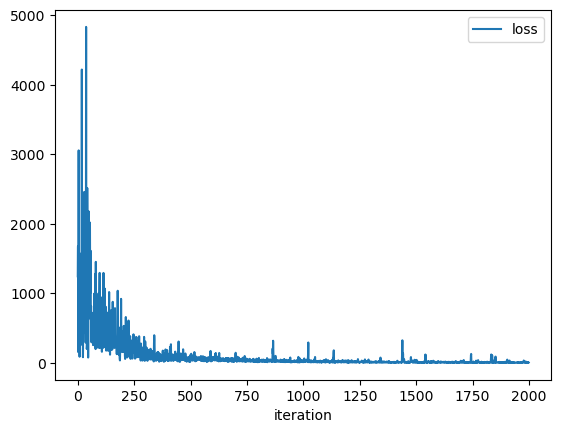

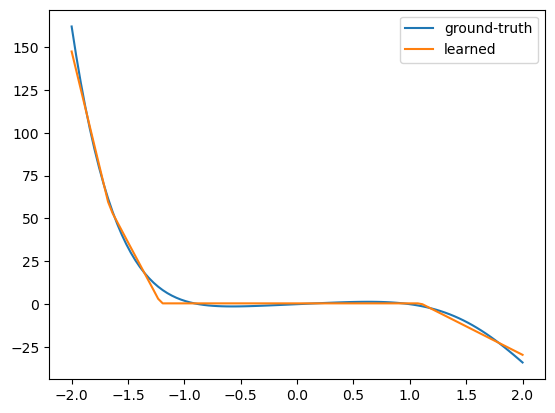

In [15]:
# TODO: vvvvvvvvvvv 
# this is a two hidden-layer fully-connected neural network
# try to change the model configuration and the hyper-parameters
# to get a mean squared error of at most 10
"""
nn.sequential() - Used to sequentially define a feed-forward model. 
Define a list of layer, and each of them process the data from 
input to output, passing it to next layer.
nn.Linear() - Create a layer as a linear transformation. Define in_features the
size of the input, and out_features the size of the transformation.
nn.ReLU() - Add non-linearity applying afther the linear layer. The inplace
parameter means that the operation will be done in place modifying the tensor.
"""
torch.manual_seed(0)
model = nn.Sequential(
    # TODO: What is the total number of parameters?
    # Number of parameters are 32 ORIGINAL model configuration
    # First layer 3weight per input + 3 bias = 6
    # Second Linear layer 1 weight per input (3) * 5 ouputs + 5 bias = 15
    # Third Linear layer 1 weight per input (5) * 1 output + 1 bias = 6
    # Total parameters implemented configuration: 
    # (4*1+4) + (4*9 + 9) + (9*1+1) = 63
    nn.Linear(in_features=1, out_features=4),
    nn.ReLU(inplace=True),
    nn.Linear(in_features=4, out_features=9),
    nn.ReLU(inplace=True),
    nn.Linear(in_features=9, out_features=1)
)

# Create dataset with x ranging from -2 to 2. 1000 numbers
xs = 2 * (torch.rand(1000, 1)*2 - 1)
dataset = TensorDataset(xs, f(xs)) # Create TensorDataset to create the tensors

# Create dataloader
data_loader = DataLoader(
    dataset,
    batch_size=20, # minibatch of 20
    shuffle=True,
    num_workers=1,
    drop_last=True,
    pin_memory=False,
    collate_fn=None,
)

# Train the model with SGD optimizer defined previusly
losses = gradient_descent(
    model=model,
    learning_rate=0.0005,
    num_epochs=40,
    data_loader=data_loader,
    criterion=nn.MSELoss(),
)

loss = sum(losses[-len(data_loader):]) / len(data_loader)
print(f'Average loss for last epoch: {loss}')

# plot the training loss
plt.plot(range(len(losses)), losses, label='loss')
plt.xlabel('iteration')
plt.legend()
plt.show()

# plot the ground-truth model vs the learned model
xs = torch.linspace(-2, 2, steps=100).unsqueeze(1)
plt.plot(xs, f(xs), label='ground-truth')
plt.plot(xs, model(xs).data, label='learned')
plt.legend()
plt.show()


# Part 2: Image Classification (5 points)

## Task 1: Logistic Regression (1.5 points)

It is now time to move on from regression to classification; the problem of assigning class labels to data points (input features). The simplest form of classification is binary classification, where each input can only be assigned one of two classes. For example, given an N-D point $\mathbf{x}$, it has class label 0 if it is inside the N-D $\ell_2$ unit sphere (i.e., $\|\mathbf{x}\|_2 < 1$ and class label 1 otherwise. Or given an image, we assign it class 1 if it contains a cat and class 0 if it doesn't. One of the basic statistical models for this task is [logistic regression](https://en.wikipedia.org/wiki/Logistic_regression). It was named as such because of the use of the [logistic function](https://en.wikipedia.org/wiki/Logistic_function) (a.k.a, sigmoid) as the last activation function. Sigmoid is a squashing function where the output range is limited in the range $[0, 1]$. So, this is why it is a perfect solution for binary classification. The output of a trained model with the sigmoid as its final layer (logits), can be thought of as the probability $p$ that the input belongs to class 1. The probability of it belonging to class 0 is going to trivially be $1 - p$. To that end, it is fitting to use the [cross entropy](https://en.wikipedia.org/wiki/Cross_entropy) loss as a criterion instead of the mean squared error loss.

In [5]:
from pathlib import Path
from torchvision import datasets
import torchvision.transforms as T

"""
Logistic regression - Supervised learning algorithm for classification tasks(e.g binary classification)
it is a linear model but instead of predicting a value it predicts the probability of an observaiton
Takes a real-valued number and output a value between [0,1]. Often trained using maximum likelihood
to find the coefficients values of the regression model that maximize the liklihood of the observed data.
"""

# Define the directory that the dataset will be downloaded
# Get the cache firectory for pytorch to create the root path
root_dir = Path(torch.hub.get_dir()) / f'datasets/MNIST'
train_set = datasets.MNIST( # create an instance of MNIST dataset
    root_dir, # provide the root path to download the dataset
    train=True, # Determine that we want to download the training dataset
    download=True, # We want to downloaded 
    # TODO: understasnd what is transform why is it needed?
    # https://stackoverflow.com/a/4674770
    # Especify a list of transformations to apply to the data
    # Convert the data to a Tensor and then normalize data
    # with mean 0.1307 and std 0.3081 (Why this values?)
    transform=T.Compose([
        T.ToTensor(),
        T.Normalize([0.1307], [0.3081]),
    ]),
)

"""
The normalization used is a min-max normalization that achieves that the pixel values
falls in a specified range. The values in the normalization are derived from the mean and
std of the pixel values of the data. It makes easier for the NN to improve accuracy and learn.
It is important to normalize the data to avoid getting stuck in a local minima helping the 
optimization function, also make training
easier, and there are some important effects on weights initialization.
"""

print(train_set)

Dataset MNIST
    Number of datapoints: 60000
    Root location: /home/ubuntu/.cache/torch/hub/datasets/MNIST
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.1307], std=[0.3081])
           )


We will be using the MNIST dataset which is a ($28 \times 28$ gray-scale hand-written digits dataset). It has 60K labeled images for training and 10K for testing. It has 10 classes (the digits 0, 1, ..., 9). Rerun the following cell multiple times to see few examples.

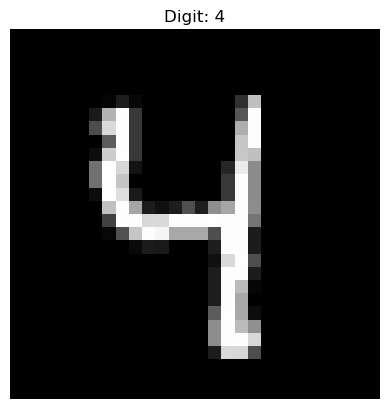

In [17]:
index = torch.randint(0, len(train_set), ()) # Create a list of index of the lenght of the train set
image, label = train_set[index] # get the tensors of the images and labels using the index

# TODO: understand the permute() here. 
# image = image.squeeze()
# To visualize the image use matplotlib 
# and we have to use permute to change the dimension order fo the tenosr
# pytorch defines the tensor as (channels,w,h) and imshow recieves (h,w,channels)
# cmap is the colorspace used to display the image
plt.imshow(image.permute((1, 2, 0)), cmap='gray')
plt.title(f'Digit: {label}')
plt.axis('off')
plt.show()

Since the task is binary classification, we will group the digits $\{0, 1, 2, 3, 4\}$ in class 0 and the digits $\{5, 6, 7, 8, 9\}$ in class 1.

Epoch #0: Loss=4.977e-01
Epoch #1: Loss=2.738e-01
Epoch #2: Loss=1.770e-01
Epoch #3: Loss=1.366e-01
Epoch #4: Loss=1.155e-01
Epoch #5: Loss=1.016e-01
Epoch #6: Loss=9.121e-02
Epoch #7: Loss=8.284e-02
Epoch #8: Loss=7.645e-02
Epoch #9: Loss=7.092e-02
Epoch #10: Loss=6.620e-02
Epoch #11: Loss=6.190e-02
Epoch #12: Loss=5.792e-02
Epoch #13: Loss=5.464e-02
Epoch #14: Loss=5.136e-02
Epoch #15: Loss=4.848e-02
Epoch #16: Loss=4.582e-02
Epoch #17: Loss=4.343e-02
Epoch #18: Loss=4.100e-02
Epoch #19: Loss=3.907e-02
Epoch #20: Loss=3.677e-02
Epoch #21: Loss=3.503e-02
Epoch #22: Loss=3.294e-02
Epoch #23: Loss=3.131e-02
Epoch #24: Loss=2.961e-02
Epoch #25: Loss=2.800e-02
Epoch #26: Loss=2.652e-02
Epoch #27: Loss=2.525e-02
Epoch #28: Loss=2.411e-02
Epoch #29: Loss=2.310e-02


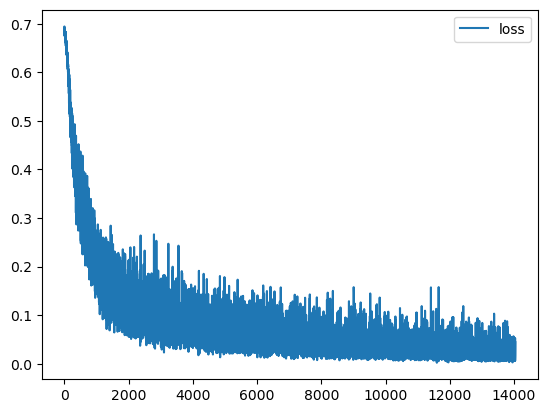

In [18]:
import torch.nn.functional as F


torch.manual_seed(0)
# TODO: understand the model here. 
# Create a sequential model
# (784*256 + 256) + (256*64 + 64) + (64*1 + 1) = 217.473
model = nn.Sequential(
    nn.Flatten(1), # Reshape image to 1 dimensional tensor
    nn.Linear(28 * 28, 256), # Input 28*28=784 params and outpur 256
    nn.ReLU(inplace=True), # Add nonlinearity and compute in the same tensor
    nn.Linear(256, 64), # input 256 (from previous layer) and output 64
    nn.ReLU(inplace=True),
    nn.Linear(64, 1), # Last layer 64 inputs and 1 output
    nn.Flatten(0), # Reshape to a scalar number
)

# TODO: vvvvvvvvvvv
# it is recommended to use F.binary_cross_entropy_with_logits(x, y)
# over F.binary_cross_entropy(torch.sigmoid(x), y)
# why?
# change it below
"""
Using F.binary_cross_entropy_with_logits(x, y) is preferred instead of 
F.binary_cross_entropy(torch.sigmoid(x), y), beacuse provide numerical stability 
and precision combining the sigmoid function and binary cross-entropy loss
in a single operation. The use of binary cross entropy with a separated sigmoid
function operation could lead to a numerical inestability encountering underflow issues.
This inestability happens when the probability is close to zero.
"""
def criterion(x, y): # Way to evaluate how good is our model to predict
#     x = torch.sigmoid(x)
    # Generate the binary labels
    # divide the groups of digits for y>=5 and y<5
    y = (y >= 5).to(dtype=torch.float) 
    return F.binary_cross_entropy_with_logits(x, y)
# ^^^^^^^^^^^^^^^^^

train_loader = DataLoader(
    train_set,
    batch_size=128,
    shuffle=True,
    num_workers=4,
    drop_last=True,
    pin_memory=False,
    collate_fn=None,
)

losses = gradient_descent(
    model,
    learning_rate=0.01,
    num_epochs=30,
    data_loader=train_loader,
    criterion=criterion,
)

plt.plot(losses, label='loss')
plt.legend()
plt.show()

Let's see how we are doing on the test set in terms of classificaiton accuracy.

In [19]:
test_set = datasets.MNIST(
    root_dir,
    train=False,
    download=True,
    transform=T.Compose([
        T.ToTensor(),
        T.Normalize([0.1307], [0.3081]),
    ]),
)

test_loader = DataLoader(
    test_set,
    batch_size=128,
    shuffle=False,
    num_workers=4,
    drop_last=False,
    pin_memory=False,
    collate_fn=None,
)


In [20]:
# evaluation mode
# compute the classification accuracy
total = 0
correct_count = 0
# Switch the model from train mode to evaluation mode
# used to evaluate the performance of the model
model.train(False)  # TODO: why? 
# No include the following in the computational graph for gradient computation
# Disable gradient computation to reduce memory usage in the evaluation or prediction
with torch.no_grad():  # TODO: why?
    for images, labels in test_loader:
        # TODO: understand how the calculation is being done.
        prediction = model(images) >= 0.5 # score >= 0.5 is one class, the other <0.5
        ground_truth = labels >= 5 # Get the binary labels for the ground truth, one class >5
        correct_count += (prediction == ground_truth).sum().item() # Compare if the prediction is correct and sum
        total += len(labels) # Count the total images predicted to compute the accuracy later
accuracy = correct_count / total # Compute the accuracy with the correct counts divided by total
print(f'{accuracy * 100:.2f}% (random classifier gives you 50%)')

# TODO: change the previous cell and note your changes here
# the goal is to reach 95% accuracy on the training set

97.49% (random classifier gives you 50%)


## Task 2: Softmax and Cross-Entropy (1.5 points)

A slightly more difficult classification problem than binary classification is multi-class classification (each sample can is assigned only one of many class labels possibly greater than 2). In such case, the size of the output is set to be equal to the number of classes, where the class prediction is the dimension with the maximum value. If we apply a hard max operator on the output, we should get 1 at the maximum value and 0's everywhere else (a.k.a [one-hot encoding](https://en.wikipedia.org/wiki/One-hot)). To get a probability as we did before, we apply a soft version of the max function (called [softmax](https://en.wikipedia.org/wiki/Softmax_function)), which normalizes the output values to sum to 1 and forces them to be in the range $[0, 1]$. With this setup, we can use the cross entropy criterion as our loss function. This is the most common setup for multi-class classification problems. It is only marginally modified for multi-label classification problems (one sample can be assigned more than one class), where a bed-of-nails is used as the target and the used criterion is the binary cross entropy loss. Regardless, we will only focus on the multi-class problem.

Epoch #0: Loss=1.773e+00
Epoch #1: Loss=5.146e-01
Epoch #2: Loss=3.513e-01
Epoch #3: Loss=2.968e-01
Epoch #4: Loss=2.608e-01
Epoch #5: Loss=2.329e-01
Epoch #6: Loss=2.097e-01
Epoch #7: Loss=1.898e-01
Epoch #8: Loss=1.732e-01
Epoch #9: Loss=1.586e-01
Epoch #10: Loss=1.462e-01
Epoch #11: Loss=1.351e-01
Epoch #12: Loss=1.253e-01
Epoch #13: Loss=1.170e-01
Epoch #14: Loss=1.090e-01
Epoch #15: Loss=1.020e-01
Epoch #16: Loss=9.519e-02
Epoch #17: Loss=8.958e-02
Epoch #18: Loss=8.433e-02
Epoch #19: Loss=7.881e-02
Epoch #20: Loss=7.448e-02
Epoch #21: Loss=7.020e-02
Epoch #22: Loss=6.618e-02
Epoch #23: Loss=6.247e-02
Epoch #24: Loss=5.919e-02
Epoch #25: Loss=5.592e-02
Epoch #26: Loss=5.321e-02
Epoch #27: Loss=4.982e-02
Epoch #28: Loss=4.761e-02
Epoch #29: Loss=4.491e-02


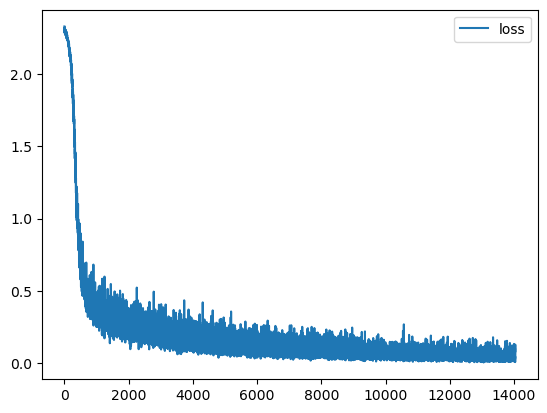

97.79% (random classifier gives you 10%)


In [21]:
# TODO: vvvvvvvvvvv
# do your magic here, the goal is 95% accuracy
# you can change the model (only using Flatten, Linear, and ReLU), the optimizer, the hyper-paremeters
torch.manual_seed(0)
model = nn.Sequential(
    nn.Flatten(1),
    nn.Linear(28 * 28, 512), # Added a new layer with 512 outputs
    nn.ReLU(inplace=True),
    nn.Linear(512, 256),
    nn.ReLU(inplace=True),
    nn.Linear(256, 64),
    nn.ReLU(inplace=True),
    nn.Linear(64, 10),
    # no need to add nn.Softmax() here
)

# this has softmax inside it already
criterion = nn.CrossEntropyLoss()

losses = gradient_descent(
    model,
    learning_rate=0.01,
    num_epochs=30,
    data_loader=train_loader,
    criterion=criterion,
)
# ^^^^^^^^^^^^^^^^^

plt.plot(losses, label='loss')
plt.legend()
plt.show()

# compute the classification accuracy
total = 0
correct_count = 0
model.train(False)
with torch.no_grad():
    for images, labels in test_loader:
        prediction = model(images).argmax(1)
        correct_count += (prediction == labels).sum().item()
        total += len(labels)
accuracy = correct_count / total
print(f'{accuracy * 100:.2f}% (random classifier gives you 10%)')

Our models are getting heavier and they started needing some hardware acceleration. It is time to update `gradient_descent()` and rewrite it to:

1. Start training on the GPU
1. Log the progress after every epoch (loss and classification accuracy)
1. Expect a validaiton data loader (inspect overfitting)
1. use a more sophisticated optimizer (e.g., Adam)
1. Put the model in training mode (some layers have different behavior between training and testing)
1. Disable unnecessarily computing gradients in evaluation mode

Advanced features that we will add in future projects.
1. Expect a learning rate scheduler (dynamically changing the learning rate)
1. Ability to save checkpoints as training progresses in case of failures
1. Ability to resume training from a saved checkpoint
1. Perform early stopping (in case of overfitting or diverging training)
1. Expect command line arguments from `argparse`

For the avid reader, check [this](http://bit.ly/dl_for_cv_05) out if you are interested in seeing an implementation of these features.

We will create a function that can be called in one of two modes; when `torch.is_grad_enabled()` is True and when it is not. The first mode is for training and the second is for validation. For now, we will use the testing dataset as our validation split (yeah, we are cheating a bit).

In [22]:
# TODO: vvvvvvvvvvv
# you should be able to explain all the introduced changes
# read: https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
# TODO: add lr_scheduler as an optional input and call its step()
def gradient_descent(model, loaders, optimizer, device, epochs, lr_scheduler=None):
    metrics = {'loss': [], 'accuracy': [], 'v_loss': [], 'v_accuracy': []}
    train = torch.is_grad_enabled() # True or False, check if grad computation is enabled
    model.train(train) # Set the model for training or evaluation (validation)
    for epoch in range(epochs): # one epoch
        count = avg_loss = avg_accuracy = 0
        # Training
        for inputs, outputs in loaders[not train]: # one iteration
            # move the inputs and outputs tensors to device
            inputs, outputs = inputs.to(device), outputs.to(device) # Send tensors to GPU
            logits = model(inputs) # forward-pass
            loss = F.cross_entropy(logits, outputs) # compute objective 
            
            if train:
                # if computation of grad is enabled then update weights
                optimizer.zero_grad() # zero out gradients
                loss.backward() # compute the gradients (backward-pass)
                optimizer.step() # take one step (update weights)
            
            # Update the metrics
            count += len(outputs)
            avg_loss += loss.item()
            avg_accuracy += (logits.data.argmax(1) == outputs).sum().item()
            
        # accumulate the metrics
        avg_loss *= len(loaders[not train])
        avg_accuracy /= count
        metrics['loss'].append(avg_loss)
        metrics['accuracy'].append(avg_accuracy)
        
        if train:

            # perform a validation epoch if done training
            with torch.no_grad():
                # TODO: this function calls itself? explain 
                # Call the same function but disabling the gradient computation
                # Useful for inference, we call it in one epoch and with no optimizer
                # This function will return the validation metrics to check overfitting
                v_metrics = gradient_descent(model, loaders, None, device, 1)
                metrics['v_loss'].append(v_metrics['loss'][0])
                metrics['v_accuracy'].append(v_metrics['accuracy'][0])
                
            # Check if the scheduler is configured and update
            if lr_scheduler != None:
                # Using ReduceLROnPlateau learning rate scheduler
                # monitor the validation loss to update the learning rate
                lr_scheduler.step(v_metrics['loss'][0]) # Adjust the learning rate, after the optimizer step
            
            # log the progress
            msg = '{}[loss={:.3e} @ accuracy={:.2f}%]'
            loss, accuracy = metrics['loss'][-1], metrics['accuracy'][-1]
            train_values = msg.format('Train', loss, accuracy * 100)
            loss, accuracy = metrics['v_loss'][-1], metrics['v_accuracy'][-1]
            val_values = msg.format('Val', loss, accuracy * 100)
            print(f'Epoch #{epoch}: {train_values} {val_values}')
    return metrics

In [23]:
def plot_metrics(metrics):
    figure, axes = plt.subplots(1, 2, figsize=(15, 5))

    epochs = range(len(metrics['loss']))
    axes[0].plot(epochs, metrics['loss'], marker='o', label='train')
    axes[0].plot(epochs, metrics['v_loss'], marker='o', label='valid')
    axes[0].set_title('Loss')
    axes[0].legend()
    axes[0].grid()

    axes[1].plot(epochs, metrics['accuracy'], marker='o', label='train')
    axes[1].plot(epochs, metrics['v_accuracy'], marker='o', label='valid')
    axes[1].set_title('Accuracy')
    axes[1].legend()
    axes[1].grid()

    plt.show(figure)
    best = max(metrics['v_accuracy']) * 100
    print(f'Best validation accuracy {best:.2f}%')

Epoch #0: Train[loss=1.432e+05 @ accuracy=79.59%] Val[loss=1.390e+03 @ accuracy=93.34%]
Epoch #1: Train[loss=3.429e+04 @ accuracy=95.24%] Val[loss=7.608e+02 @ accuracy=96.16%]
Epoch #2: Train[loss=2.129e+04 @ accuracy=97.05%] Val[loss=6.063e+02 @ accuracy=96.98%]
Epoch #3: Train[loss=1.591e+04 @ accuracy=97.77%] Val[loss=4.973e+02 @ accuracy=97.58%]
Epoch #4: Train[loss=1.230e+04 @ accuracy=98.22%] Val[loss=5.143e+02 @ accuracy=97.51%]
Epoch #5: Train[loss=9.794e+03 @ accuracy=98.60%] Val[loss=4.974e+02 @ accuracy=97.44%]
Epoch #6: Train[loss=7.995e+03 @ accuracy=98.84%] Val[loss=5.526e+02 @ accuracy=97.51%]
Epoch #7: Train[loss=6.797e+03 @ accuracy=98.96%] Val[loss=4.800e+02 @ accuracy=97.78%]
Epoch #8: Train[loss=5.807e+03 @ accuracy=99.14%] Val[loss=5.926e+02 @ accuracy=97.28%]
Epoch #9: Train[loss=4.432e+03 @ accuracy=99.31%] Val[loss=5.356e+02 @ accuracy=97.82%]
Epoch #10: Train[loss=3.897e+03 @ accuracy=99.45%] Val[loss=5.747e+02 @ accuracy=97.73%]
Epoch #11: Train[loss=4.338e+03

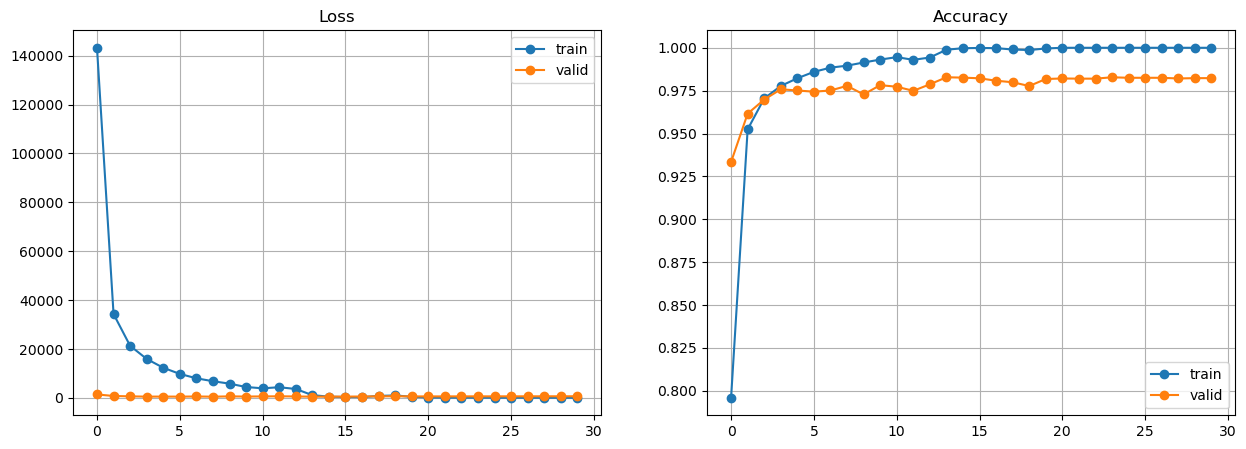

Best validation accuracy 98.28%


In [24]:
# TODO: vvvvvvvvvvv
# do your magic here, the goal is 98.20% "validation" accuracy
# learn more about regularization: https://stats.stackexchange.com/a/18765
# tricks like (dropout, weight decay, learning rate scheduling) might help
# see what others have tried https://stats.stackexchange.com/q/376312
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
"""
Regularization Techniques
Regularization is a method to prevent overfitting(complex model fit to closely to the data) and 
underfitting(model not able to recognize the unerlying patterns in data). Regularization improve 
the generalization ability tunning the complexity or smoothness of the model. 
- L1, L2 regularization: Add a penalty to the loss function to have smaller weights. L2(weight decay)
- Dropout: Reduce model capacity by randomly drop out neurons with a given probability
    use dropout after ReLU activation, to regularize the ouput of the neurons and aims generalization
    ReLU tends to become some neurons highly active.
- Early stopping: Stop the training when the validation loss start to decrease
"""
"""
Learning rate decay
Technique to reduce the update the learning rate in the training. Start with a high lr value to
get big improvements at the beginining, but then gradually decrease to get more precise updates.
This aims to converge faster and to have a better solution.
"""
torch.manual_seed(0)
model = nn.Sequential(
    nn.Flatten(1),
    nn.Linear(28 * 28, 128),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(128, 64),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(64, 10),
)

device = torch.device('cuda:0')  # select which GPU (index 0)
loaders = (train_loader, test_loader)  # train must be before test
# move model to device before you initialize the optimizer
optimizer = torch.optim.Adam(model.to(device).parameters())

# StepLR - Reduce the lr after the defined step_size
# scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

# ReduceLROnPlateau, dynamically reduce the learning rate when a metric
# stops improving. Aims to find a better minimum.
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=4, factor=0.5, verbose=True)

metrics = gradient_descent(model, loaders, optimizer, device, epochs=30, lr_scheduler=scheduler)
plot_metrics(metrics)
# ^^^^^^^^^^^^^^^^^

## Task 3: Convolutional Neural Networks (1.5 points)

<table>
  <tbody>
    <tr>
      <td><img width="150px" src="https://github.com/vdumoulin/conv_arithmetic/raw/master/gif/no_padding_no_strides.gif"></td>
      <td><img width="150px" src="https://github.com/vdumoulin/conv_arithmetic/raw/master/gif/arbitrary_padding_no_strides.gif"></td>
      <td><img width="150px" src="https://github.com/vdumoulin/conv_arithmetic/raw/master/gif/same_padding_no_strides.gif"></td>
      <td><img width="150px" src="https://github.com/vdumoulin/conv_arithmetic/raw/master/gif/full_padding_no_strides.gif"></td>
    </tr>
    <tr>
      <td>No padding, no strides</td>
      <td>Arbitrary padding, no strides</td>
      <td>Half padding, no strides</td>
      <td>Full padding, no strides</td>
    </tr>
    <tr>
      <td><img width="150px" src="https://github.com/vdumoulin/conv_arithmetic/raw/master/gif/no_padding_strides.gif"></td>
      <td><img width="150px" src="https://github.com/vdumoulin/conv_arithmetic/raw/master/gif/padding_strides.gif"></td>
      <td><img width="150px" src="https://github.com/vdumoulin/conv_arithmetic/raw/master/gif/padding_strides_odd.gif"></td>
      <td><h5><i><b>Source:</b> <a href="https://github.com/vdumoulin/conv_arithmetic">vdumoulin</a></i></h5></td>
    </tr>
    <tr>
      <td>No padding, strides</td>
      <td>Padding, strides</td>
      <td>Padding, strides (odd)</td>
      <td></td>
    </tr>
  </tbody>
</table>

Images have a nice 2D sturcture and adjacent pixels have some sort of uniformity. When we are working with fully connected networks, we lose a huge advantage. This is why we should leverage natural operations like 2D convolutions. In convolutional neural networks (CNNs), the image gets processed first with few convolutional layers the goal is to diminish the the spatial dimensions and focus on more hierarchically semantic features by expanding the channel dimension. Convolutional layers are usually followed by pooling layers to inforce this even further.


A batch of input images in PyTorch has this shape [BatchSize $\times$ Channels $\times$ Height $\times$ Width]. If they are gray-scale images, Channels = 1, and if they are RGB, Channels = 3. After a convolutional layer, they the spatial dimensions usually gets smaller or stay the same (depending on the padding, strides, kernel size, and dilation). Consult the [documentation](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) for a concrete formula. [This tutorial](http://bit.ly/dl_for_cv_04) compares MLPs and CNNs.

Epoch #0: Train[loss=9.770e+04 @ accuracy=85.24%] Val[loss=6.699e+02 @ accuracy=96.60%]
Epoch #1: Train[loss=2.279e+04 @ accuracy=96.80%] Val[loss=5.828e+02 @ accuracy=96.91%]
Epoch #2: Train[loss=1.577e+04 @ accuracy=97.76%] Val[loss=2.882e+02 @ accuracy=98.68%]
Epoch #3: Train[loss=1.203e+04 @ accuracy=98.29%] Val[loss=3.347e+02 @ accuracy=98.13%]
Epoch #4: Train[loss=1.029e+04 @ accuracy=98.53%] Val[loss=3.428e+02 @ accuracy=98.17%]
Epoch #5: Train[loss=8.434e+03 @ accuracy=98.85%] Val[loss=1.951e+02 @ accuracy=98.99%]
Epoch #6: Train[loss=7.328e+03 @ accuracy=98.94%] Val[loss=1.662e+02 @ accuracy=99.07%]
Epoch #7: Train[loss=6.046e+03 @ accuracy=99.12%] Val[loss=2.057e+02 @ accuracy=98.97%]
Epoch #8: Train[loss=5.320e+03 @ accuracy=99.22%] Val[loss=2.130e+02 @ accuracy=98.92%]
Epoch #9: Train[loss=4.300e+03 @ accuracy=99.35%] Val[loss=1.621e+02 @ accuracy=99.14%]
Epoch #10: Train[loss=3.851e+03 @ accuracy=99.46%] Val[loss=1.944e+02 @ accuracy=98.99%]
Epoch #11: Train[loss=3.564e+03

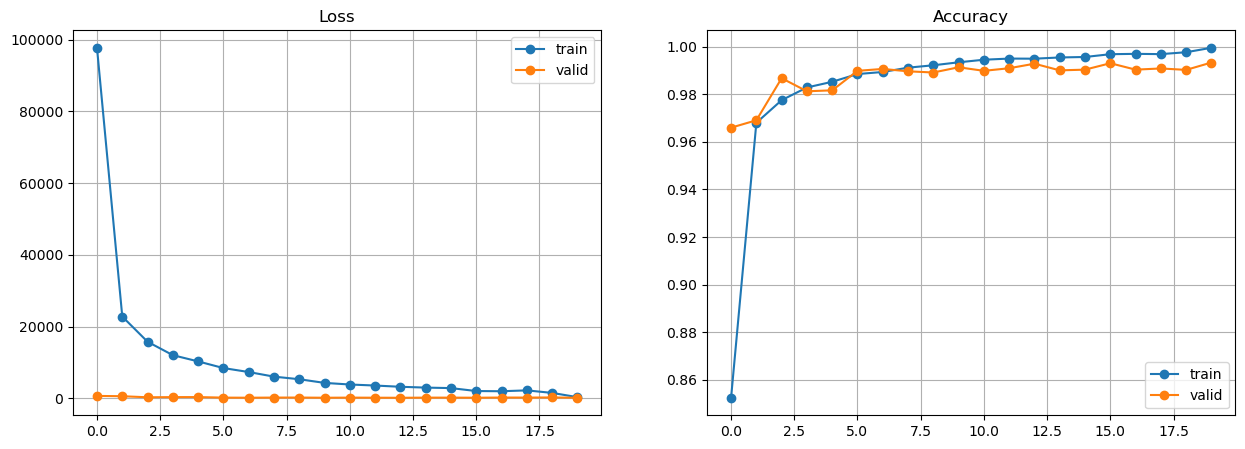

Best validation accuracy 99.34%


In [25]:
# TODO: vvvvvvvvvvv
# build a CNN of at least two nn.Conv2d() layers and one pooling layer 
# followed by a flatten layer and one or more linear layers
# the goal is to achieve 99.30% validation accuracy
# see AlexNet https://pytorch.org/hub/pytorch_vision_alexnet/
# you should be able to discuss the the trends of in the plots
"""
With 2D convolutions the spatial dimentions reduce and expand channel dimensions
the convolution help to identify local patterns and features.
Expanding the channel dims aims to learn high level features
Shape of CNN input [BatchSize x Channels x Height x Width] 
pooling layer to enforce spatial dimensions reducing enforcing spatial invariance.

nn.Conv2d() - Perform 2D convolutions on 2D input data
    - in_channels: Input channels (grayscale 1 channel, RGB 3 channels)
    - out_channels: Number of filters to apply. Each filter learn to detect a feature
    - kernel_size: convolutional kernel or filter size
    - stride: How many pixels to move the kernel
    - padding: Amount of padding to apply to the input

What is the method to design convolutional layers?
Number of filters, filter size, 

"""
torch.manual_seed(0)
model = nn.Sequential(
    # dimension of the output filters
    # (input_size - filter + 2*padding)/ stride + 1
    nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1), #14x14x32
    nn.ReLU(True),
    nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), #7x7x64
    nn.ReLU(True),
    nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), #7x7x128
    nn.ReLU(True),
    # Transform the output of the conv layer to a fixed size 3x3
    nn.AdaptiveAvgPool2d((3, 3)), 
    # Flatten 3x3x128=1152 vector
    nn.Flatten(1),
    # Fully connected layers 3
    # (1152*64 + 64) = 73792
    nn.Linear(128 * 3 * 3, 64),
    nn.ReLU(True),
    # (64*32 + 32) = 2080
    nn.Linear(64, 32),
    nn.ReLU(True),
    # (32*10 + 10) = 330
    nn.Linear(32, 10),
)

device = torch.device('cuda:0')  # select which GPU (index 0)
loaders = (train_loader, test_loader)  # train must be before test
# move model to device before you initialize the optimizer
optimizer = torch.optim.Adam(model.to(device).parameters())
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.1, verbose=True)
metrics = gradient_descent(model, loaders, optimizer, device, epochs=20, lr_scheduler=scheduler)
plot_metrics(metrics)
# ^^^^^^^^^^^^^^^^^

In [26]:
# from torchsummary import summary
# from torchviz import make_dot
# summary(model, (1,28,28))

Nice, let's move on to another image dataset. CIFAR10 is a $32 \times 32$ RGB images dataset that contains 10 classes. [Here](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html) is a light official tutorial for training a CNN on CIFAR10. We need to differentiate between validation dataset (a subset of the training set for hyper-parameters tuning) and test sets (for reporting the model's performance).

In [4]:
import torch
from matplotlib import pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torchvision.transforms as T
from pathlib import Path
from torchvision import datasets
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

In [2]:
from torch.utils.data import random_split

"""
Data Augmentation - Used to improve the the ability of the model
to generalize unseen data. Consist of generate new examples for current data
aiming to increase size and quality of the dataset.
Operations to perform data augmentation
flipping, rotating, cropping, resizing, adding noise, brightness and
contrst, applying color shifts.
"""


root_dir = Path(torch.hub.get_dir()) / f'datasets/CIFAR10'
# Normalize with values calculate from the dataset
normalize = T.Normalize(
    mean=(0.4915, 0.4823, 0.4468),
    std=(0.2470, 0.2435, 0.2616),
)
# Inverse of normalization to convert
# normalized data to original scale and range
inv_normalize = T.Normalize(
    mean= [-m / s for m, s in zip(normalize.mean, normalize.std)],
    std= [1 / s for s in normalize.std]
)

train_set = datasets.CIFAR10(
    root_dir,
    train=True,
    download=True,
    transform=T.Compose([
        # TODO: vvvvvvvvvvv
        # read about http://wikipedia.org/wiki/Data_augmentation
        # take a look here https://pytorch.org/vision/stable/transforms.html
        # add some randomaization to improve the generalization
        # at least use 3 other transforms
        # Add randomaization to improve generalization
        T.RandomApply(nn.ModuleList([
            T.ColorJitter(brightness=.1, hue=.1), 
        ]), p=0.25),
        # Transformations from torchvision.transforms
        T.RandomPerspective(distortion_scale=0.1, p=0.5), # distortion scale in images with p prob
        T.RandomHorizontalFlip(p=0.5), # Random horizontal flip
#         T.RandomVerticalFlip(p=0.5), # Random vertical flip
        T.RandomPosterize(bits=4), # Get images with reduced num of colors
        T.ToTensor(),
        normalize,
#         T.RandomErasing(p=0.25), # Applied directly on the tensor
        # ^^^^^^^^^^^^^^^^^
    ]),
)
test_set = datasets.CIFAR10(
    root_dir,
    train=False,
    download=True,
    transform=T.Compose([
        T.ToTensor(),
        normalize,
    ]),
)

print(train_set)
print(test_set)

# split the training set into 40K training and 10K validation
train_set, val_set = random_split(train_set, [40000, 10000])


Files already downloaded and verified
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: /home/ubuntu/.cache/torch/hub/datasets/CIFAR10
    Split: Train
    StandardTransform
Transform: Compose(
               RandomApply(
               p=0.25
               ColorJitter(brightness=[0.9, 1.1], contrast=None, saturation=None, hue=[-0.1, 0.1])
           )
               RandomPerspective(p=0.5)
               RandomHorizontalFlip(p=0.5)
               RandomPosterize(bits=4,p=0.5)
               ToTensor()
               Normalize(mean=(0.4915, 0.4823, 0.4468), std=(0.247, 0.2435, 0.2616))
           )
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: /home/ubuntu/.cache/torch/hub/datasets/CIFAR10
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.4915, 0.4823, 0.4468), std=(0.247, 0.2435, 0.2616))
           )


In [6]:
# TODO: vvvvvvvvvvv
# create data loaders for the three data splits
# make sure to have pin_memory=True (working on a GPU)
train_loader = DataLoader(
    train_set,
    batch_size=128,
    shuffle=True,
    num_workers=4,
    drop_last=True,
    pin_memory=True,
    collate_fn=None,
)

val_loader = DataLoader(
    val_set,
    batch_size=128,
    shuffle=True,
    num_workers=4,
    drop_last=True,
    pin_memory=True,
    collate_fn=None,
)

test_loader = DataLoader(
    test_set,
    batch_size=128,
    shuffle=True,
    num_workers=4,
    drop_last=False,
    pin_memory=True,
    collate_fn=None,
)

# ^^^^^^^^^^^^^^^^^

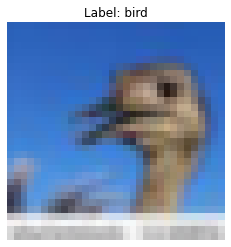

In [7]:
import torchvision.transforms.functional as TF


index = torch.randint(0, len(train_set), ())
image, label = train_set[index]

plt.imshow(TF.to_pil_image(inv_normalize(image)))
label = train_set.dataset.classes[label]
plt.title(f'Label: {label}')
plt.axis('off') 
plt.show()

Epoch #0: Train[loss=1.943e+05 @ accuracy=23.17%] Val[loss=1.018e+04 @ accuracy=39.47%]
Epoch #1: Train[loss=1.403e+05 @ accuracy=46.76%] Val[loss=8.024e+03 @ accuracy=52.07%]
Epoch #2: Train[loss=1.208e+05 @ accuracy=55.08%] Val[loss=7.210e+03 @ accuracy=57.79%]
Epoch #3: Train[loss=1.076e+05 @ accuracy=60.40%] Val[loss=6.519e+03 @ accuracy=61.30%]
Epoch #4: Train[loss=1.002e+05 @ accuracy=63.43%] Val[loss=6.283e+03 @ accuracy=63.23%]
Epoch #5: Train[loss=9.270e+04 @ accuracy=66.04%] Val[loss=5.957e+03 @ accuracy=65.65%]
Epoch #6: Train[loss=8.745e+04 @ accuracy=68.21%] Val[loss=5.570e+03 @ accuracy=67.93%]
Epoch #7: Train[loss=8.314e+04 @ accuracy=69.63%] Val[loss=5.541e+03 @ accuracy=67.93%]
Epoch #8: Train[loss=7.887e+04 @ accuracy=71.53%] Val[loss=5.300e+03 @ accuracy=69.37%]
Epoch #9: Train[loss=7.548e+04 @ accuracy=72.42%] Val[loss=5.105e+03 @ accuracy=70.81%]
Epoch #10: Train[loss=7.262e+04 @ accuracy=73.64%] Val[loss=5.026e+03 @ accuracy=71.10%]
Epoch #11: Train[loss=6.959e+04

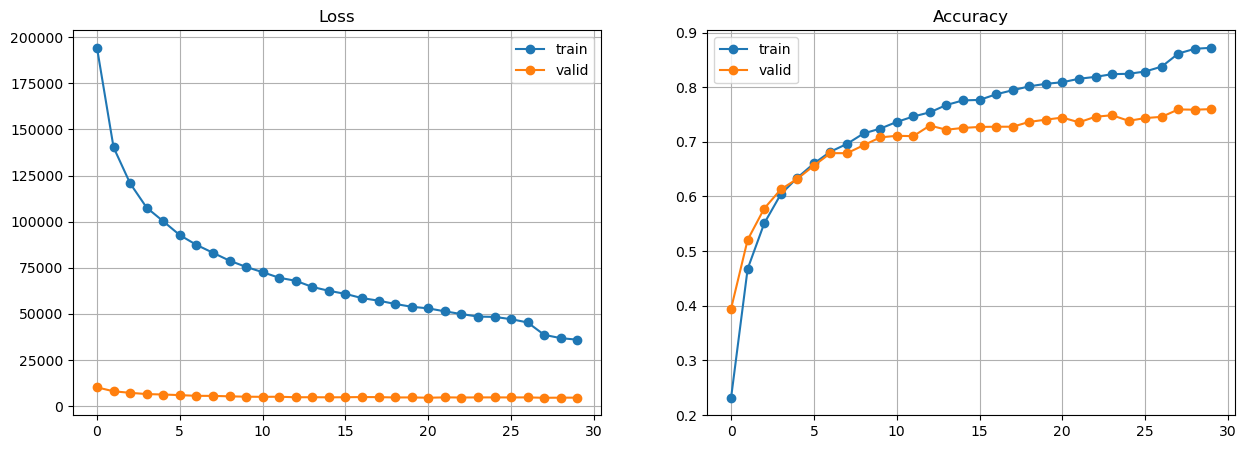

Best validation accuracy 75.99%
Test accuracy of the last model 77.27%


In [31]:
# TODO: vvvvvvvvvvv
# build a CNN to achieve 70.00% "test" accuracy
torch.manual_seed(0)
model = nn.Sequential(
    # (input_size - filter + 2*padding)/ stride + 1
    # First Convolutional layer
    nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1), #32x32x32
    nn.ReLU(True),
    nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), #16x16x64
    nn.ReLU(True),
    nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1), #8x8x128
    nn.ReLU(True),
    # Transform the output of the conv layer to a fixed size 4x4
    nn.AdaptiveAvgPool2d((4, 4)), 
    # Flatten 4x4x128=2048 vector
    nn.Flatten(1),
    # Fully connected layers 3
    # (2048*64 + 64) = 73792
    nn.Linear(128 * 4 * 4, 64),
    nn.ReLU(True),
    nn.Dropout(0.5),
    # (64*32 + 32) = 2080
    nn.Linear(64, 32),
    nn.ReLU(True),
    nn.Dropout(0.5),
    # (32*10 + 10) = 330
    nn.Linear(32, 10),
)


device = torch.device('cuda:0')  # select which GPU (index 0)
loaders = (train_loader, val_loader)  # train must be before test
# move model to device before you initialize the optimizer
optimizer = torch.optim.Adam(model.to(device).parameters())
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.1, verbose=True)
metrics = gradient_descent(model, loaders, optimizer, device, epochs=30, lr_scheduler=scheduler)
plot_metrics(metrics)

with torch.no_grad():
    test_accuracy = gradient_descent(
        model, (None, test_loader), None, device, epochs=1)['accuracy'][0]
print(f'Test accuracy of the last model {test_accuracy * 100:.2f}%')
# ^^^^^^^^^^^^^^^^^

# Part 3: Video Classification (2.5 points)

There are many video datasets [available](https://datasetsearch.research.google.com/) for free online intended for research purposes, such as [YouTube-8M](https://research.google.com/youtube8m/) and [ActivityNet](http://activity-net.org/). We will be using the [YouTubeVideoGame](https://ai.googleblog.com/2013/11/released-data-set-features-extracted.html) dataset which contains multiview (multi-modal) hand-crafted video features (vision, text, and audio) extracted from 120K YouTube videos of people playing 30+ popular video games. The authors of this dataset hid the original YouTube video links. All what we have is just the extracted vision, text and audio features for each video (inputs) and the class label of the featured game (output). We are only interested in the vision features. You can get the dataset and learn more about it from [here](https://code.google.com/archive/p/multiview-video-features-data/wikis/InfoOnData.wiki).

The vision modality has 5 feature families, similar to the audio modality, while the text has only 3. Combined, they are 13 feature families. Each feature family is an N-dimensional feature vector collected using some [feature extraction method](https://deepai.org/machine-learning-glossary-and-terms/feature-extraction) (e.g., 
[HOG](https://en.wikipedia.org/wiki/Histogram_of_oriented_gradients) features). Every feature family was saved into a sperate compressed text file `*.txt.gz`. They also, split the training set from the validation from the testing set. Thus, we will create a dataset class for every feature family (called `YTVGFeatureFamily`) and create another dataset class combining feature families of the same split (train, validation, test) and modality (called `YouTubeVideoGame`).

Skim through the following code-cell very quickly. It defines `YTVGFeatureFamily`. The most relavent parts are `__getitem__` and `__len__`. The former method is to give you one sample given its index and the later to return the total number of samples in the dataset. It also has a flag `by_video_id` to use video ids instead of indices. Most of these features have high sparsity (most values are zeros). Therefore, they opted to store the features in the sparse [COO(rdinate) format](https://pytorch.org/docs/1.7.1/sparse.html). However, there is no need to fret as it can be easly converted to the regular dense format by calling `Tensor.to_dense()`.

In [10]:
import torch
from matplotlib import pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torchvision.transforms as T
from pathlib import Path
from torchvision.utils import make_grid
from torchvision import datasets
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

In [5]:
import torch
import gzip
from pathlib import Path
from torch.utils.data import Dataset


class YTVGFeatureFamily(Dataset):
    """YouTube Video Game Dataset (YTVG).

    http://ai.googleblog.com/2013/11/released-data-set-features-extracted.html
    http://code.google.com/archive/p/multiview-video-features-data/

    YTVG dataset has 13 feature family divided into three modalities;
    vision (5 families), audio (5 families), and text (3 families).

    Args:
        file_path: path to the *.txt.gz feature family file.
        by_video_id: accessing items is by video_id instead of index.

    """

    modalities = {
        'vision': (
            'cuboids_histogram',
            'hs_hist_stream',
            'hist_motion_estimate',
            'misc',
            'hog_features',
        ),
        'audio': (        
            'mfcc',
            'sai_intervalgrams',
            'sai_boxes',
            'volume_stream',
            'spectrogram_stream',
        ),
        'text': (
            'description_unigrams',
            'tag_unigrams',
            'game_lda_1000',
        ),
    }

    def __init__(self, file_path, by_video_id=False):
        self.file_path = Path(file_path)

        # whether to select items by video id or index
        self.by_video_id = bool(by_video_id)

        # placeholders for the data
        self.index = {}  # key: video_id, value: index
        self.video_id = []
        self.class_label = []
        self.indices = []
        self.values = []

        # read all the instances (videos) in the *.txt.gz file
        with gzip.open(self.file_path, 'rt') as txt_gz:
            instances = iter(txt_gz.read().split('#I'))
            next(instances)

        # parse each instace
        for index, instance in enumerate(instances):
            video_id, class_label, *features = instance.split()
            if features:
                indices, values = zip(*map(lambda x: x.split(':'), features))
            else:
                indices, values = [], []
            indices = torch.LongTensor(tuple(map(int, indices))) - 1
            values = torch.FloatTensor(tuple(map(float, values)))

            self.index[int(video_id)] = index
            self.video_id.append(int(video_id))
            self.class_label.append(int(class_label) - 1)
            self.indices.append(indices)
            self.values.append(values)
                               
        # get the size of this feature (maximum among all instances)
        self.size = max(i.max().item() for i in self.indices if len(i)) + 1

    @property
    def name(self):
        return self.file_path.name.split('.')[0]

    @property
    def modality(self):
        return self.file_path.name.split('_')[0]

    def __getitem__(self, index):
        if self.by_video_id:
            index = self.index[index]
        i = self.indices[index].unsqueeze(0)
        v = self.values[index]
        feature = torch.sparse.FloatTensor(i, v, (self.size,))
        return {
            'index': index,
            'video_id': self.video_id[index],
            'class_label': self.class_label[index],
            'feature': feature,
        }

    def __len__(self):
        return len(self.video_id)

    def __contains__(self, video_id):
        return video_id in self.index

    def __repr__(self):
        return f'{type(self).__name__}({self.name}_{self.size})'

You cannot test the previous class before downloading and extracting its files. The following dataset class (`YouTubeVideoGame`) should be able to download these for you. If the automatic download failed, you can download them yourself using the links that you will get prompted. These are large files they could take around 2GB of RAM after they are loaded.

In [6]:
from torchvision.datasets.utils import extract_archive
from torchvision.datasets.utils import download_file_from_google_drive


class YouTubeVideoGame(Dataset):
    """YouTube Video Game Dataset (YTVG).

    http://ai.googleblog.com/2013/11/released-data-set-features-extracted.html
    http://code.google.com/archive/p/multiview-video-features-data/

    Args:
        data_dir: root directory for data files.
        modality: must be in {'vision', 'audio', 'text'}.
        split: must be in {'train', 'validation', 'test'}.

    """

    file_id = {
        # Google Drive file ids
        'dir_vision': '0B4ZwSjYLbUK3Qmp0YWR2ckVKc2c',
        'dir_audio1': '0B4ZwSjYLbUK3dFVTa0hvMGJxdXc',
        'dir_audio2': '0B4ZwSjYLbUK3NTUyU0pQUDFpc3c',
        'dir_text': '0B4ZwSjYLbUK3WnMwTW93a1Bmc28',
        'validation': '0B4ZwSjYLbUK3ZDlZRG9pazZ6eGc',
        'test': '0B4ZwSjYLbUK3SjJJX1UtSThBZnM',
    }
    md5 = {
        # MD5 values for each file
        'dir_vision': 'b8c5bc715405d526716008ee792589c0',
        'dir_audio1': '5f10d11c2c601ff80e775c1a2ef361d3',
        'dir_audio2': '7d3ca965c9f430451799b3d68ac51498',
        'dir_text': '1e21c10b38df59b8c488f99607ff814e',
        'validation': 'e975214da0ff36702b9e649c0ee32035',
        'test': 'ae11b3769eb46c62cd72ddc8252694bf',
    }

    def __init__(self, data_dir=None, modality='vision', split='train'):
        self.data_dir = data_dir
        self.modality = modality
        self.split = split

        # select the correct data files
        files = []
        if self.split == 'train':
            if self.modality == 'vision':
                files.append('dir_vision')
            elif self.modality == 'audio':
                files.append('dir_audio1')
                files.append('dir_audio2')
            elif self.modality == 'text':
                files.append('dir_text')
        else:
            files.append(self.split)

        # download the files and load feature families
        self.features = []
        for tar in files:
            self.download_and_extract(tar)
            for name in YTVGFeatureFamily.modalities[self.modality]:
                gz = self.data_dir / f'{tar}/{self.modality}_{name}.txt.gz'
                print(f'loading {gz} ...')
                feature = YTVGFeatureFamily(gz, by_video_id=True)
                self.features.append(feature)

    @classmethod
    def default_dir(cls):
        """Get the default dataset files directory."""
        return Path(torch.hub.get_dir()) / f'datasets/{cls.__name__}'

    @property
    def data_dir(self):
        """Get dataset files directory."""
        return self._data_dir

    @data_dir.setter
    def data_dir(self, path):
        if path is None:
            path = self.default_dir()
        self._data_dir = Path(path)

    def download_and_extract(self, file_name):
        """Download and extract a dataset file."""
        directory = self.data_dir / file_name
        path = self.data_dir / (file_name + '.tar')
        if not directory.exists():
            file_id = self.file_id[file_name]
            print(f'did not find {str(directory)}')
            print(f'downloading https://drive.google.com/file/d/{file_id}')
            print(f'if it is taking more than expected, download it yourself')
            print(f'you should then rename it and place it here {path}')
            download_file_from_google_drive(
                file_id=file_id,
                root=self.data_dir,
                filename=file_name + '.tar',
                md5=self.md5[file_name],
            )
            extract_archive(str(path))

    @property
    def size(self):
        return sum(f.size for f in self.features)

    def __getitem__(self, index):
        video_id = self.features[0].video_id[index]
        output = self.features[0][video_id]
        output['feature'] = []
        for feature in self.features:
            if video_id in feature:
                vector = feature[video_id]['feature']
            else:
                size = torch.Size([feature.size])
                vector = torch.sparse.FloatTensor(size)
            output['feature'].append(vector)
        output['feature'] = torch.cat(output['feature'])
        return output

    def __len__(self):
        return len(self.features[0])

    def __repr__(self):
        return f'{type(self).__name__}({self.modality}_{self.split})'


# this may take a while to download and a while to load
test_set = YouTubeVideoGame(modality='vision', split='test')
val_set = YouTubeVideoGame(modality='vision', split='validation')
train_set = YouTubeVideoGame(modality='vision', split='train')


loading /home/ubuntu/.cache/torch/hub/datasets/YouTubeVideoGame/test/vision_cuboids_histogram.txt.gz ...
loading /home/ubuntu/.cache/torch/hub/datasets/YouTubeVideoGame/test/vision_hs_hist_stream.txt.gz ...
loading /home/ubuntu/.cache/torch/hub/datasets/YouTubeVideoGame/test/vision_hist_motion_estimate.txt.gz ...
loading /home/ubuntu/.cache/torch/hub/datasets/YouTubeVideoGame/test/vision_misc.txt.gz ...
loading /home/ubuntu/.cache/torch/hub/datasets/YouTubeVideoGame/test/vision_hog_features.txt.gz ...
loading /home/ubuntu/.cache/torch/hub/datasets/YouTubeVideoGame/validation/vision_cuboids_histogram.txt.gz ...
loading /home/ubuntu/.cache/torch/hub/datasets/YouTubeVideoGame/validation/vision_hs_hist_stream.txt.gz ...
loading /home/ubuntu/.cache/torch/hub/datasets/YouTubeVideoGame/validation/vision_hist_motion_estimate.txt.gz ...
loading /home/ubuntu/.cache/torch/hub/datasets/YouTubeVideoGame/validation/vision_misc.txt.gz ...
loading /home/ubuntu/.cache/torch/hub/datasets/YouTubeVideoGam

The dataset has 31 classes $[0, 30]$ (30 games + 1 unspecified). The unspecified class (background class) includes all videos of games that are not in the previous 30 classes. Unfortunately, the `__getitem__()` function returns a `dict`, while our implementation of `gradient_descent()` expects a `tuple` of two values; in input dense feature vector and an output class label. `YouTubeVideoGame` doesn't even offer a way to add transforms for each item. So, we will need to create a wrapper class for `YouTubeVideoGame` (called `YTVG` for short).

In [11]:
# TODO: vvvvvvvvvvv
# compelete the wrapper class
# add small Gaussian noise to features if self.augment is True
# comment the noise out if it hurts the generalizaiton
"""
The YTVG dataset contains 13 families of features (3 text, 5 audio, 5 video),
we are reading the families for video data:
    - cuboids_histogram
    - hs_hist_stream
    - hist_motion_estimate
    - misc
    - hog_features
    
The wrapper handle the loaded dataset and convert the features tensors from
sparse to dense tensors and add gaussian noise to the training dataset.

The dimension of the feature tensors is [3085]. Given that the tensor describe
features of the video clips we can use some fully connected layers to learn
how to classify the dataset.
"""
class YTVG(Dataset):
    def __init__(self, dataset, augment=False):
        self.dataset = dataset
        self.augment = augment
#         print(self.dataset)

    def __getitem__(self, index):
        output = self.dataset[index]
        class_label = output['class_label']
        # Convert the sparse tensor to a dense feature vector
        features = output['feature'].to_dense()
        if self.augment:
            # Add gaussian noise to the features tensor
            features += 0.1*torch.randn(features.shape)
        return features, class_label

    def __len__(self):
        return len(self.dataset)

    def __repr__(self):
        return repr(self.dataset)
# ^^^^^^^^^^^^^^^^^

# wrap the datasets
if isinstance(train_set, YouTubeVideoGame):
    train_set_ = YTVG(train_set, augment=False)
if isinstance(val_set, YouTubeVideoGame):
    val_set_ = YTVG(val_set)
if isinstance(test_set, YouTubeVideoGame):
    test_set_ = YTVG(test_set)
    
# feat, _ = train_set_[5]
# print(feat.shape)
print(train_set_, len(train_set))
print(val_set_, len(val_set))
print(test_set_, len(test_set))

YouTubeVideoGame(vision_train) 97934
YouTubeVideoGame(vision_validation) 12177
YouTubeVideoGame(vision_test) 11930


In [12]:
# TODO: vvvvvvvvvvv
# create the data loaders
train_loader = DataLoader(
    train_set_,
    batch_size=128,
    shuffle=True,
    num_workers=4,
    drop_last=True,
    pin_memory=True,
    collate_fn=None,
)

val_loader = DataLoader(
    val_set_,
    batch_size=128,
    shuffle=True,
    num_workers=4,
    drop_last=True,
    pin_memory=True,
    collate_fn=None,
)

test_loader = DataLoader(
    test_set_,
    batch_size=128,
    shuffle=True,
    num_workers=4,
    drop_last=False,
    pin_memory=True,
    collate_fn=None,
)

# ^^^^^^^^^^^^^^^^^

Epoch #0: Train[loss=1.458e+06 @ accuracy=32.98%] Val[loss=1.520e+04 @ accuracy=50.06%]
Epoch #1: Train[loss=8.222e+05 @ accuracy=60.50%] Val[loss=1.091e+04 @ accuracy=66.48%]
Epoch #2: Train[loss=6.365e+05 @ accuracy=70.00%] Val[loss=9.422e+03 @ accuracy=71.17%]
Epoch #3: Train[loss=5.392e+05 @ accuracy=74.44%] Val[loss=8.654e+03 @ accuracy=73.94%]
Epoch #4: Train[loss=4.742e+05 @ accuracy=77.43%] Val[loss=8.185e+03 @ accuracy=75.14%]
Epoch #5: Train[loss=4.235e+05 @ accuracy=79.71%] Val[loss=7.938e+03 @ accuracy=76.59%]
Epoch #6: Train[loss=3.816e+05 @ accuracy=81.71%] Val[loss=7.620e+03 @ accuracy=77.07%]
Epoch #7: Train[loss=3.448e+05 @ accuracy=83.43%] Val[loss=7.629e+03 @ accuracy=77.75%]
Epoch #8: Train[loss=3.126e+05 @ accuracy=84.98%] Val[loss=7.570e+03 @ accuracy=78.40%]
Epoch #9: Train[loss=2.845e+05 @ accuracy=86.41%] Val[loss=7.693e+03 @ accuracy=78.26%]
Epoch #10: Train[loss=2.598e+05 @ accuracy=87.58%] Val[loss=7.559e+03 @ accuracy=78.78%]
Epoch #11: Train[loss=2.366e+05

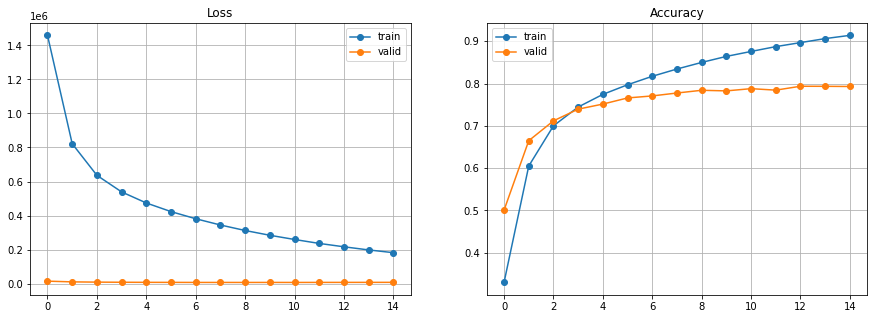

Best validation accuracy 79.35%
Test accuracy of the last model 79.30%


In [13]:
# TODO: vvvvvvvvvvv
# train a deep model on the vision modality of YouTubeVideoGame dataset
# you must plot training and validation loss and accuracy per epoch 
# and report the final testing accuracy as we did in the previous parts
# there is no target accuracy required feel free to experiments ;) 
"""
Seems that the model is not generalizing well due to the training data.
The noise added to the training set makes harder to fit by the model, rather
than the validation dataset. With the gaussian noise added the validation accuracy
is better than the training accuracy. Train[loss=1.356e+06 @ accuracy=34.27%] Val[loss=1.704e+04 @ accuracy=45.38%]

In multiple experiments the best score achieved for the validation accuracy
was nearly 79%. Using architectures with multiple Linear layers and many neurons
I got overfitting achieving 99% in training while the validation converged to 
78%. Reducing the size of the network achieved good test results.
"""
torch.manual_seed(0)

model = nn.Sequential(
    nn.Linear(3085, 128),
    nn.ReLU(inplace=True),
#     nn.Dropout(0.5),
#     nn.Linear(512, 256),
#     nn.ReLU(inplace=True),
#     nn.Dropout(0.5),
#     nn.Linear(256, 128),
#     nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(128, 64),
    nn.ReLU(inplace=True),
    nn.Linear(64, 31),
)

# Select which GPU (index 0)
device = torch.device('cuda:0')
loaders = (train_loader, test_loader)
# move the model to device before initialize the optimizer
optimizer = torch.optim.Adam(model.to(device).parameters())
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.1, verbose=True)

metrics = gradient_descent(model, loaders, optimizer, device, epochs=15, lr_scheduler=scheduler)
plot_metrics(metrics)

with torch.no_grad():
    test_accuracy = gradient_descent(
        model, (None, test_loader), None, device, epochs=1)['accuracy'][0]
print(f'Test accuracy of the last model {test_accuracy * 100:.2f}%')

# ^^^^^^^^^^^^^^^^^

## On Vision Transformers

If there's a word that you heard too many times, it's transformers. In this project we are interested in exploring Vision Transformers (ViTs). In 2022, ViTs emerged as a competitive alternative to convolutional neural networks (CNNs). Transformer architecture was first introduced in natural language processing (NLP) and later was extended to image classification (and other vision tasks), check [An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale](https://arxiv.org/pdf/2010.11929v2.pdf). Without going back and forth we directly jump into the various components of a ViT architecture.

1. Split an image into patches (fixed sizes).

2. Flatten the image patches.

3. Create lower-dimensional linear embeddings from these flattened image patches.

4. Include positional embeddings.

5. Feed the sequence as an input to a state-of-the-art transformer encoder.

6. Pre-train the ViT model with image labels, which is then fully supervised on a big dataset.

7. Fine-tune the downstream dataset for image classification

![Vision Transformers](https://viso.ai/wp-content/uploads/2021/09/vision-transformer-vit.png)

Please read the following posts to get a better understanding of ViTs before proceeding to the below TODOs!

* https://lilianweng.github.io/posts/2020-04-07-the-transformer-family/

* https://jalammar.github.io/illustrated-transformer/


In [ ]:
"""
The Illustrated Transformer

Boost speed of training, also lends to parallelization.
Model
    Encoders (identical in structure, stack of this elements)
        self-attention - Helps the encoder look other words
            Method that the transformer look for other relevant words related
            to the current processing word.
            Three vectors from multiplication of W matrices with input vector
                - query vector dim64
                - key vector dim64
                - value vector dim64
            Calculare score multiplying Query and Key vector
            Divide by 8 and pass to a softmax to normalize scores
            Multiply with the value vector to drown irrelevant words
            Then finaly sum up the wierighted value vectors
            This layer uses multi-headed attention and get Z weighted vectors
            Use W0 matrix to produce one output.
            To add the positional argument to maitain the input sequence
            it is added a vector to each embedding.
        Feed Forward NN - Output from self-attention layer
            In each encoder exist a resudual connection followed by a 
            layer normalization step.
    
    Decoders 
        use vectors k and v from the encoder part to focus on appropiate places of input
        self-attention - Helps the encoder look other words
        Encoder-Decoder Attention - Focus decoder on relevant parts of input
        Feed Forward NN - Output from self-attention layer
    
    Final fully connected layer and softmax
        projects vectors from the stach of decoders to a logits vector
        softmax turn to probabilities.

Words embedded in a 512 vector each of them. Embed the words in the input sequence of the
encoder.
The encoders receive a list of vectors as input. 

"""

""" 
The Transformer Family

Attention and self-attention
self-attention mechanism where the model makes prediction of some
data sample using other parts of the same sample, model can learn to predict by attend selectively to a given set
of data.

Multi-head self-attention
splits inputs in smaller chunks to compute the attention over each subspace 
in parallel. The independent outputs are concatenated and linearly transformed to
the desired dimensions. The benefit is that the model attend multiple
parts of the input simultaneously(achieveing state of the art).

In the transformer architecture, the attention mechanism used is called
dot product attention. Given query matrix, key matrix, and value matrix. The output
is a weighted sum of the value vectors. Weight = query.key

The transformer is a neural net architecture in NLP that is based on 
Encoder-Decoder Architecture. The encoder generates an attention based
representation of the input, and the decoder return infomation from the
encoder to obtain the ouput sequence.

Encoder 
    6 identical models
        Each model contains:
        - multi-head attention layer
            Allows the model to selectively attend different parts
            of the input sequence.
        - point-wise fully connected feedforward network
            Perform same linear transformation to each element in sequence
        This submodules have residual connection and layer normalization

Decoder
    Consist of identical modules like the encoder
    - 1 masked multi-head attention submodule
        masked to prevent position from attending to future positions
        in the output sequence. Allows the encoder to attend the positions
        that have already been generated. Model can make predictions only
        in the information generated so far.
    - 1 multi-head attention submodule
    - Feed forward submodule

The positional encoding is added to the input and in NLP can be defined 
as sinosoidal positional encoding.

Longer Attention Span (Transformer-XL)
Address the limitation of the vanilla transformer in handling long sequencs
This transforemer introduce a recurrence mechanism that allows the model
to attenf previous timestep tokens. With this, the model can have longer
attention span.

Adaptative attention span
Adapt attendtion span lenght and attend further back in the sequence when needed
Dynamically adjust the attention span of the transformer based on the input
sequence.

Localized Attention Span (Image Transformer)
Idea is replace the self-attention mechanism with a localized attention mechanis
that only attends to nearby images patches. 
Encoder - Generates a contextualized, per-pixel channel representation of image
Decoder - Autoregressively generates an ouput image, one channel per pixel.
2D local attention - Image devided in multiple non-overlapping query blocks.
The query pixel can attend to all others in the same memory blocks.
    

"""

In each assignmnet we will have a ViT related task. Today's task is achieving steps 1 and 2, that is we need to first patchify the images then flatten them so we could later feed into an embedding layer.

In [11]:
# patchify the image

def convert_image_to_patches(image, patch_size):
    """
    As discussed above, Vision Transformers Require Patchification of the input image.
    This function takes an image tensor and returns a tensor of patches. (# Batches, # Patches, # Channels, Patch Size, Patch Size)

    images - PyTorch tensor containing the images of a batch and has the shape [B, C, H, W]
    patch_size - Number of pixels per dimension of the patches (integer)
    
    expected output: PyTorch tensor of shape [B, N, C, patch_size, patch_size] where N is the number of patches obtained from the image after patchification.
    """

    # TODO: fill in the blanks to patchify the image 
    B, C, H, W = image.shape
    
    # Compute number of patches per image
    num_patches = (H//patch_size)*(W//patch_size)
    
    # METHOD 1 - Extract the patches using for loops
    
    # Create a tensor with the desired structure 
    # patched_tensor = torch.zeros(B, num_patches, C, patch_size, patch_size)
    # print(patched_tensor[0,0].shape)
    
    # for idx, img in enumerate(image):
    #     # loop to read each image from the batch of images
    #     # print(f"Index: {idx} with shape {img.shape}")
    #     # Count the patch to be extracted
    #     patch_idx = 0
    #     # Iterate on each image of the batch
    #     for i in range(0, H, patch_size): # iterate over the height 
    #         for j in range(0, W, patch_size): # iterate over the width
    #             # iterate over the image to crop the patches 
    #             # and add to the zeros torch tensor
    #             # Step value equal to patch_size to obtain non-overlapping patches
    #             crop_image = img[:,i:i+patch_size, j:j+patch_size]
    #             patched_tensor[idx,patch_idx] = crop_image # reeplace the 
    #             patch_idx += 1
        
    
    # Method 2 - Extract the patches using unfold method from pytorch 
    patches = image.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)
    # print(patches.shape)
    patches = patches.contiguous().view(B, C, -1, patch_size, patch_size) # MEANING
    patches = patches.permute(0,2,1,3,4)
    # print(patches.shape)
    
    # B, C, H, W = x.shape

    # x = x.reshape()
    # x = x.permute() 
    # x = x.flatten()              

    return patches


Files already downloaded and verified
Patch size: 5
Batch original shape: torch.Size([128, 3, 32, 32])
Patched tensor shape: torch.Size([128, 36, 3, 5, 5])


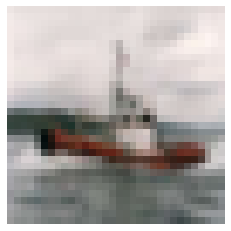

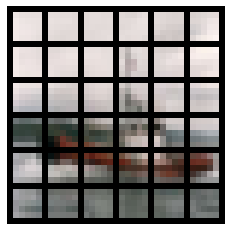

In [14]:
# TODO: Visualize the patches in an image grid using torchvision.utils.make_grid or matplotlib subplots or a tool of your choice.
# Use the test_set of CIFAR10 to test the function

test_set = datasets.CIFAR10(
    root_dir,
    train=False,
    download=True,
    transform=T.Compose([
        T.ToTensor(),
    ]),
)
test_loader = DataLoader(
    test_set,
    batch_size=128,
    shuffle=True,
    num_workers=4,
    drop_last=False,
    pin_memory=True,
    collate_fn=None,
)

patch_size = 5
for inputs, outputs in test_loader:
    print(f"Patch size: {patch_size}")
    print(f"Batch original shape: {inputs.shape}")
    # Call the function to convert the image to patches
    patches = convert_image_to_patches(inputs, patch_size)
    print(f"Patched tensor shape: {patches.shape}")
    # Show the complete image
    plt.imshow(TF.to_pil_image(inputs[0]))
    plt.axis('off')
    plt.show()
    # Create grid of images with the patches
    grid = make_grid(patches[0], nrow=32//patch_size, padding=1, normalize=False)
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis('off')
    plt.show()
    break

In [15]:
#TODO: Now we need to flatten the patches into a vector. A simple way to do that is use .flatten() function of PyTorch. We need to pass Batch x Patches x Flatten_Dim.
# Flatten_Dim represents the obtained vector dimension after flattening (C x patch_size x patch_size).

""" 
We need to flatten the patches into a vector to pass to the 
"""
patch_size = 5
for inputs, outputs in test_loader:
    # Call the function to convert the image to patches
    print(f"Patch size: {patch_size}")
    print(f"Batch original shape: {inputs.shape}")
    patches = convert_image_to_patches(inputs, patch_size)
    print(f"Patched tensor shape: {patches.shape}")
    tensor_flatten = torch.flatten(patches, start_dim=2)
    print(f"Flatten tensor shape: {tensor_flatten.shape}")
    break
    
    
    

Patch size: 5
Batch original shape: torch.Size([128, 3, 32, 32])
Patched tensor shape: torch.Size([128, 36, 3, 5, 5])
Flatten tensor shape: torch.Size([128, 36, 75])
